# Inhaltsübersicht EDA
TD = To Do, TBD = To Be Determined)

### 1. Überblick über den Datensatz
- Spaltenbeschreibung/Datentypen: Funktion overview()
- Fehlende Werte (NaN-Anteile berechnet, diskutiert)

- TD: evtl. kurze Beschreibung der Daten (Ursprung, Umfang) --> ins Datenwörterbuch oder DataHowTo

### 2. Datenbereinigung
- Entfernen unrealistischer Ausreißer (Schadstoffe, Wetterdaten) --> Städte auch noch überprüfen?
- Zellenweise Ersetzung durch NaN (statt Zeilenlöschung)
- Dokumentaton der Schwellenwerte und Filterlogik

- TD: evtl. Tabelle oder Text mit Anzahl der entfernten/extremen Werte

### 3. Deskriptive Statistik (Grundanalyse)
- describe()-Tabellen für Schadstoffe und Wetterdaten
- Vergleich von Mean und Median zu Einschätzung der Schiefe
- Berechnung der Schiefe (skew)

### 4. Visualisierungen
- Stripplots zur Ausreißererkennung für alle numerischen Spalten
- Histogramme für ausgewählte Variablen, zur Visualisierung der Schiefe hauptsächlich, aber auch für Platzhalterwerte
- Korrelationsmatrix (Pearson) --> Dreieck

- TD: Lineplots mit Mittelwert und Streuung (für einzelnen Schadstoffe, noch ausbaufähig)
- TD: Weitere Diagramme nach Gruppen (Stadt, Jahr, Kontinent, etc.)

### 5. Korrelationsanalyse
- Korrelationen berechnet und interpretiert
- Stärkste Korrelationen identifiziert und dokumentiert
- Empfehlung zur Variablenselektion (evtl. PCA) gegeben

### 6. Prüfung auffälliger Größen/Städte (Feedback-Loop aus der Clusteranalyse; weiter oben bei Ausreißerbestimmung einbauen?)
- Geprüft wurden: Ashkelon, Ashdod, Netanya

- TD: Weitere Städte prüfen (z.B. Tehran noch mal genau berechnen)

### 7. Vorbereitung für Clustering und andere Modellierungen
- Welche Features sollen verwendet werden?
- Standardisierung / Skalierung wie?
- Ziel der Clusteranalyse formulieren

Allgemein: Dokumentation & Kommunikation
- Kommentare und Begründungen im Code, aber mit Markdown
- Einführung und Fazit zur EDA?
- Strukturierung der finalen NB-Version für GitHub
- TD: Einzelergebnisse abspeichern als csv



# Fragen/Kommentare von Mareike an Wiebke

- Abschnitt 1: Was machen wir mit den Bevölkerungsdaten? 78% fehlen. Kleine separate Analyse nur mit den Städten, wo wir die Daten haben?

- Die bereinigten Daten, ohne Ausreißer habe ich in "cleaned_air_quality_data" & Datum gespeichert. Das Datum nehmen wir am Ende wohl besser wieder raus. Das ist nur jetzt eine Krücke, falls was kaputtgeht.




# 0. Datensatz laden

- Spaltennamen überprüfen
- redundante Spalten entfernen

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# import os
# import matplotlib
# import datetime

In [2]:
# Settings for displaying floats
pd.set_option('display.float_format', '{:,.2f}'.format)

In [3]:
df = pd.read_csv("./data/cleaned_data.csv")
df.head()

,Year,Month,Day,Country,City,Latitude,Longitude,Population,Co,No2,...,Wind-speed,Dew,Humidity,Tavg,Tmin,Tmax,Prcp,Wdir,Wspd,Pres
0,2014,12,29,AT,Graz,47.07,15.45,"269,997.00",0.10,9.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014,12,29,AT,Innsbruck,47.26,11.39,"124,579.00",0.10,25.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014,12,29,AT,Linz,48.31,14.29,"193,814.00",0.10,14.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014,12,29,AT,Salzburg,47.80,13.04,"146,631.00",0.10,21.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014,12,29,AT,Vienna,48.21,16.37,NaN,0.10,9.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.columns

# Some redundant columns still need to be removed from df manually: Temperature, Pressure, Wind-speed

Index(['Year', 'Month', 'Day', 'Country', 'City', 'Latitude', 'Longitude',
       'Population', 'Co', 'No2', 'O3', 'Pm10', 'Pm25', 'Pressure', 'So2',
       'Temperature', 'Wind-gust', 'Wind-speed', 'Dew', 'Humidity', 'Tavg',
       'Tmin', 'Tmax', 'Prcp', 'Wdir', 'Wspd', 'Pres'],
      dtype='object')

In [5]:
# Drop redundant columns (--> könnte man auch in der cleaning pipeline machen)

df = df.drop(columns=['Temperature', 'Wind-speed', 'Pressure'])
df.columns

Index(['Year', 'Month', 'Day', 'Country', 'City', 'Latitude', 'Longitude',
       'Population', 'Co', 'No2', 'O3', 'Pm10', 'Pm25', 'So2', 'Wind-gust',
       'Dew', 'Humidity', 'Tavg', 'Tmin', 'Tmax', 'Prcp', 'Wdir', 'Wspd',
       'Pres'],
      dtype='object')

# 1. Überblick über den Datensatz verschaffen

- Überblicksfunktion .overview()
- Fehlende Werte ausloten und Spalten mit < 50% Daten entfernen --> Das müssen wir noch besprechen (Population)

In [6]:
# Function to create overview for dtypes, missing values, unique values

def overview(df):
    '''
    Erstelle einen Überblick über einige Eigenschaften der Spalten eines DataFrames.
    VARs
        df: Der zu betrachtende DataFrame
    RETURNS:
        None
    '''
    display(pd.DataFrame({'dtype': df.dtypes,
                          'total': df.count(),
                          'missing': df.isna().sum(),
                          'missing%': df.isna().mean()*100,
                          'n_uniques': df.nunique(),
                          'uniques%': df.nunique()/df.shape[0]*100,
                          'uniques': [df[col].unique() for col in df.columns]
                         }))


In [7]:
overview(df)

,dtype,total,missing,missing%,n_uniques,uniques%,uniques
Year,int64,1695041,0,0.00,12,0.00,"[2014, 2015, 2016, 2017, 2018, 2019, 2020, 202..."
Month,int64,1695041,0,0.00,12,0.00,"[12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]"
Day,int64,1695041,0,0.00,31,0.00,"[29, 30, 31, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11..."
Country,object,1695041,0,0.00,95,0.01,"[AT, AU, BE, BO, BR, CA, CH, CL, CN, CO, CY, C..."
City,object,1695041,0,0.00,616,0.04,"[Graz, Innsbruck, Linz, Salzburg, Vienna, Bris..."
Latitude,float64,1692212,2829,0.17,617,0.04,"[47.06667, 47.26266, 48.30639, 47.79941, 48.20..."
Longitude,float64,1692212,2829,0.17,616,0.04,"[15.45, 11.39454, 14.28611, 13.04399, 16.37208..."
Population,float64,363474,1331567,78.56,1289,0.08,"[269997.0, 124579.0, 193814.0, 146631.0, nan, ..."
Co,float64,1063231,631810,37.27,1009,0.06,"[0.1, 1.9, 2.1, nan, 2.3, 2.0, 3.4, 5.5, 3.8, ..."
No2,float64,1408781,286260,16.89,1291,0.08,"[9.0, 25.6, 14.2, 21.1, 4.6, 0.7, nan, 6.5, 4...."


In [8]:
# Focus on missing values: Sort missing values (descending)

missing_percent = df.isna().mean() * 100
missing_percent_sorted = missing_percent.sort_values(ascending=False)

print(missing_percent_sorted)


Population   78.56
Wind-gust    54.21
Dew          40.99
Prcp         38.73
Co           37.27
So2          31.44
Wdir         31.00
Pres         29.03
Wspd         26.90
Humidity     22.90
O3           22.07
Pm10         20.17
Tmax         18.93
Tmin         18.79
Tavg         17.35
No2          16.89
Pm25         15.50
Longitude     0.17
Latitude      0.17
Month         0.00
City          0.00
Country       0.00
Day           0.00
Year          0.00
dtype: float64


In [9]:
# Remove all columns with more than 50% missing values
# Note: This removes population data entirely!

# Anzahl der Spalten vor dem Entfernen merken
original_columns = df.shape[1]

df = df.loc[:, missing_percent <= 50]

# Print what has changed
print(f"Anzahl der entfernten Spalten: {original_columns - df.shape[1]}") 
print("Übrige Spalten:", df.columns)

df.head()

Anzahl der entfernten Spalten: 2
Übrige Spalten: Index(['Year', 'Month', 'Day', 'Country', 'City', 'Latitude', 'Longitude',
       'Co', 'No2', 'O3', 'Pm10', 'Pm25', 'So2', 'Dew', 'Humidity', 'Tavg',
       'Tmin', 'Tmax', 'Prcp', 'Wdir', 'Wspd', 'Pres'],
      dtype='object')


,Year,Month,Day,Country,City,Latitude,Longitude,Co,No2,O3,...,So2,Dew,Humidity,Tavg,Tmin,Tmax,Prcp,Wdir,Wspd,Pres
0,2014,12,29,AT,Graz,47.07,15.45,0.10,9.00,NaN,...,1.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014,12,29,AT,Innsbruck,47.26,11.39,0.10,25.60,NaN,...,1.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014,12,29,AT,Linz,48.31,14.29,0.10,14.20,NaN,...,2.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014,12,29,AT,Salzburg,47.80,13.04,0.10,21.10,NaN,...,2.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014,12,29,AT,Vienna,48.21,16.37,0.10,9.00,NaN,...,2.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df.columns

Index(['Year', 'Month', 'Day', 'Country', 'City', 'Latitude', 'Longitude',
       'Co', 'No2', 'O3', 'Pm10', 'Pm25', 'So2', 'Dew', 'Humidity', 'Tavg',
       'Tmin', 'Tmax', 'Prcp', 'Wdir', 'Wspd', 'Pres'],
      dtype='object')

In [11]:
df.shape

(1695041, 22)

# Deskriptive Statistik

Dataset has many variables. Statistics will be split up into pollutants, weather and location

# Analysis of data on pollutants

In [12]:
# Pollutants

pollutant_cols = ["Co", "Pm25", "Pm10", "So2", "No2", "O3"]
df[pollutant_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
Co,"1,063,231.00",4.77,8.89,0.00,1.40,3.40,5.60,500.00
Pm25,"1,432,252.00",53.25,41.04,0.00,25.00,42.00,67.00,999.00
Pm10,"1,353,189.00",27.07,27.69,0.00,12.00,19.00,34.00,999.00
So2,"1,162,066.00",3.98,8.82,0.00,1.20,2.50,4.30,500.00
No2,"1,408,781.00",9.76,10.50,0.00,4.60,7.50,12.40,500.00
O3,"1,320,893.00",20.46,15.39,0.00,11.80,19.90,27.20,500.00


Einige Messwerte wie Co = 500 oder Pm25 = 999 deuten auf Platzhalter für fehlende oder ungültige Daten hin und verzerren die Verteilung erheblich. Diese Werte könnten fehlerhaft sein und sollten aus der Analyse ausgeschlossen werden.

## Analyse und Bereinigung der Pm25-Werte

In [13]:
df["Pm25"].sort_values(ascending=False).unique() [:10]

array([999., 981., 834., 832., 831., 826., 825., 824., 818., 816.])

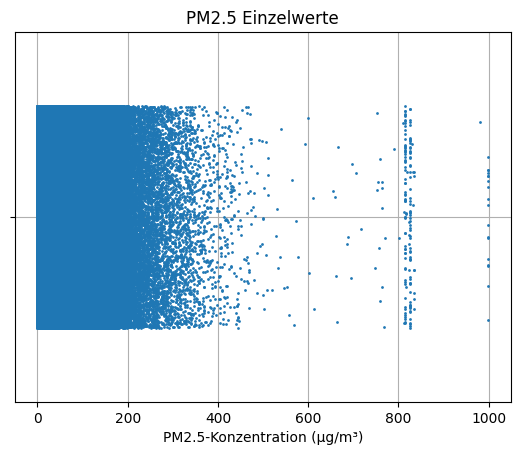

In [14]:
sns.stripplot(x=df["Pm25"], size=2, jitter=0.3)
plt.title("PM2.5 Einzelwerte")
plt.xlabel("PM2.5-Konzentration (µg/m³)")
plt.grid(True);

### Interpretation der Pm25-Werte VOR Bereinigung des Datensatzes
Bei der visuellen Analyse der PM2.5-Messwerte fällt eine ungewöhnliche Häufung im Bereich zwischen 816 und 834 µg/m³ auf, begleitet von vereinzelten extrem hohen Werten bei 981 und 999 µg/m³. Diese Werte liegen deutlich außerhalb des realistischen Messbereichs und deuten auf Messfehler, Platzhalterwerte oder systembedingte Übertragungsfehler hin. Um die Analyse nicht zu verzerren, werden daher alle PM2.5-Werte ab 816 µg/m³ ausgeschlossen.

In [15]:
# PM2.5 >= 816
df.loc[df["Pm25"] >= 816, "Pm25"] = np.nan

<Axes: xlabel='Pm25', ylabel='Count'>

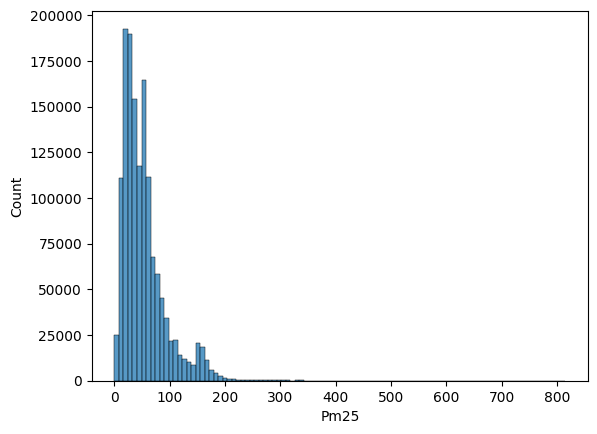

In [16]:
sns.histplot(df["Pm25"], bins=100)

Die Verteilung der Messwerte wirkt nach dem Entfernen der unrealistischen Werte rechtsschief. Überprüfung mit Vergleich Mean/Median.

In [17]:
mean_pm25 = df["Pm25"].mean()
median_pm25 = df["Pm25"].median()

print(f"Mittelwert (mean): {mean_pm25:.2f}")
print(f"Median:            {median_pm25:.2f}")

Mittelwert (mean): 53.19
Median:            42.00


In [18]:
from scipy.stats import skew

skew_pm25 = skew(df["Pm25"].dropna())
print(f"Schiefe (Skewness): {skew_pm25:.2f}")

# Skewness > 0 --> rechtsschiefe Verteilung.

Schiefe (Skewness): 2.26


### Verteilung der bereinigten PM2.5-Werte (Fazit)

Die PM2.5-Werte zeigen eine deutlich rechtsschiefe Verteilung. Der Mittelwert liegt bei 53,19 µg/m³, während der Median nur 42,00 µg/m³ beträgt. Zusätzlich ergibt die Berechnung der Schiefe (Skewness) einen Wert von 2,26, was auf eine starke Asymmetrie hindeutet.
Diese rechtsschiefe Verteilung bedeutet, dass der Großteil der Messwerte im unteren Bereich liegt, während einige wenige sehr hohe Werte den Mittelwert nach oben ziehen.

Um die Analyse nicht durch technisch bedingte Ausreißer zu verzerren, wurden alle PM2.5-Werte ab 816 µg/m³ ausgeschlossen, da sie deutlich außerhalb des natürlichen Messbereichs liegen und teilweise systematisch auftraten.

## Analyse und Bereinigung der CO-Werte

In [19]:
df["Co"].sort_values(ascending=False).unique()[:30]

array([500. , 496. , 495.3, 495. , 489.2, 485.5, 478.1, 426.4, 425.3,
       420.4, 416. , 397.6, 380.8, 374.5, 357.3, 341. , 333.4, 324.4,
       315.9, 315.5, 308.6, 288. , 281.3, 277.5, 277.1, 271.8, 270.3,
       267.4, 266.4, 266. ])

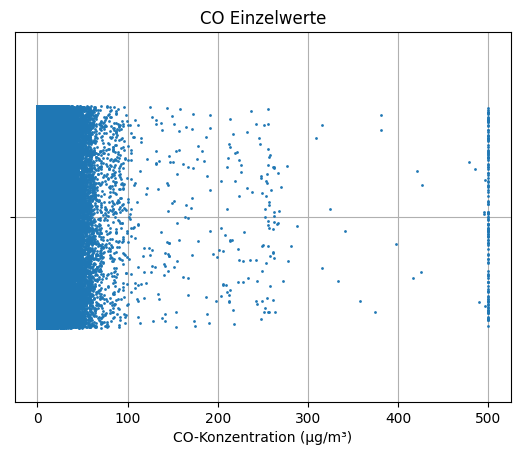

In [20]:
sns.stripplot(x=df["Co"], size=2, jitter=0.3)
plt.title("CO Einzelwerte")
plt.xlabel("CO-Konzentration (µg/m³)")
plt.grid(True);

### Interpretation der Pm25-Werte VOR Bereinigung des Datensatzes
Es gibt zwar einen eindeutigen Platzhalterwert, aber alle anderen Messwerte könnten theoretisch realistisch sein. Überprüfung der Verteilung mit Mean/Median, um den Cutoff festzulegen.

In [21]:
mean_co = df["Co"].mean()
median_co = df["Co"].median()
skew_co = skew(df["Co"].dropna())

print(f"Mittelwert (mean): {mean_co:.2f}")
print(f"Median:            {median_co:.2f}")
print(f"Schiefe:           {skew_co:.2f}")

Mittelwert (mean): 4.77
Median:            3.40
Schiefe:           27.96


### Bereinigte CO-Werte (Begründung)

Die Verteilung der CO-Messwerte ist stark rechtsschief, mit einem Mittelwert von 4.74 µg/m³, einem Median von 3.40 µg/m³ und einer Schiefe von 29.64. Dies deutet auf extreme Ausreißer hin, die den Mittelwert erheblich verzerren. Zusätzlich tritt eine auffällige Häufung exakt bei 500 µg/m³ auf, was sehr wahrscheinlich ein technischer Platzhalterwert ist.

Um die Aussagekraft der Analyse zu erhöhen, wurden daher alle Werte ab 300 µg/m³ ausgeschlossen. Dieser Grenzwert liegt deutlich oberhalb der Hauptverteilung und entfernt sowohl technische Ausreißer als auch extreme Einzelwerte.

In [22]:
# CO > 300 oder CO == 500 → als NaN
df.loc[df["Co"] >= 300, "Co"] = np.nan

## Analyse und Bereinigung der No2-Werte

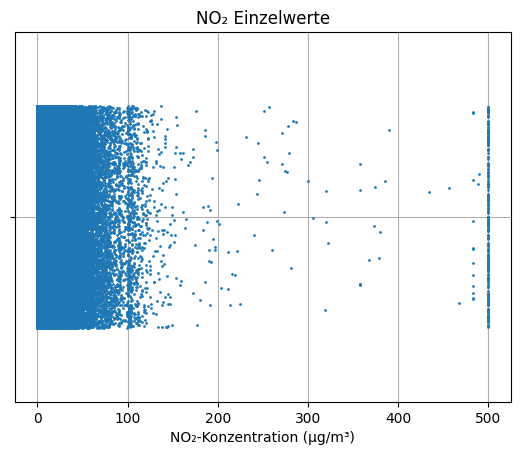

In [23]:
sns.stripplot(x=df["No2"], size=2, jitter=0.3)
plt.title("NO₂ Einzelwerte")
plt.xlabel("NO₂-Konzentration (µg/m³)")
plt.grid(True);

In [24]:
mean_no2 = df["No2"].mean()
median_no2 = df["No2"].median()
skew_no2 = skew(df["No2"].dropna())

print(f"Mittelwert (mean): {mean_no2:.2f}")
print(f"Median:            {median_no2:.2f}")
print(f"Schiefe:           {skew_no2:.2f}")

Mittelwert (mean): 9.76
Median:            7.50
Schiefe:           19.34


<Axes: xlabel='No2', ylabel='Count'>

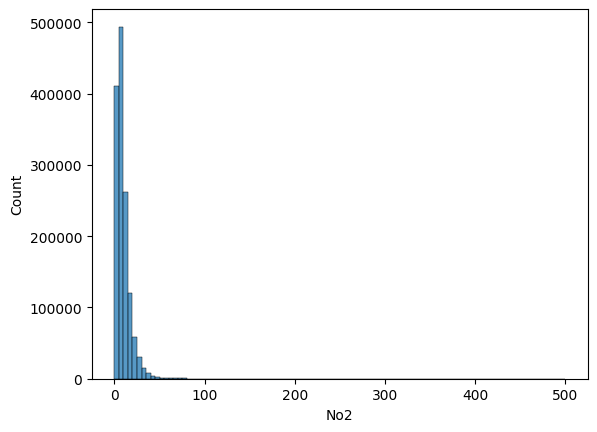

In [26]:
sns.histplot(df["No2"], bins=100)

In [27]:
# NO2 >= 300 oder == 500
df.loc[df["No2"] >= 300, "No2"] = np.nan

### Bereinigung der NO₂-Werte
Die NO₂-Werte zeigen eine stark rechtsschiefe Verteilung, mit einem Mittelwert von 10.55 µg/m³, einem Median von 8.40 µg/m³ und einer Schiefe von 10.08. Die große Mehrheit der Messwerte liegt unterhalb von 120 µg/m³, während einzelne Ausreißer bis 425 µg/m³ reichen. 

Zusätzlich tritt eine auffällige Häufung bei 500 µg/m³ auf, was sehr wahrscheinlich auf technische Platzhalterwerte zurückzuführen ist.
Um die Analyse nicht durch extreme Einzelwerte zu verzerren, wurden alle NO₂-Werte ab 300 µg/m³ ausgeschlossen.

In [28]:
df["No2"].describe()

count   1,408,527.00
mean            9.67
std             8.29
min             0.00
25%             4.60
50%             7.50
75%            12.40
max           299.80
Name: No2, dtype: float64

## Analyse und Bereinigung der So2-Werte

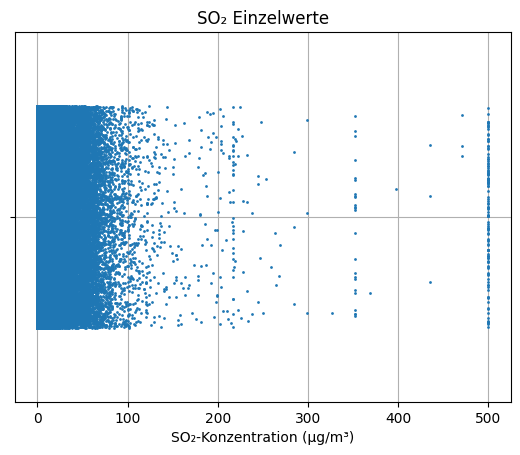

In [29]:
sns.stripplot(x=df["So2"], size=2, jitter=0.3)
plt.title("SO₂ Einzelwerte")
plt.xlabel("SO₂-Konzentration (µg/m³)")
plt.grid(True);

In [30]:
mean_so2 = df["So2"].mean()
median_so2 = df["So2"].median()
skew_so2 = skew(df["So2"].dropna())

print(f"Mittelwert (mean): {mean_so2:.2f}")
print(f"Median:            {median_so2:.2f}")
print(f"Schiefe:           {skew_so2:.2f}")

Mittelwert (mean): 3.98
Median:            2.50
Schiefe:           25.75


In [31]:
# SO2 >= 300 oder == 500
df.loc[df["So2"] >= 300, "So2"] = np.nan

### Bereinigung der SO₂-Werte
Die Verteilung der Schwefeldioxid-Werte ist stark rechtsschief, mit einem Mittelwert von 4.10 µg/m³, einem Median von 2.60 µg/m³ und einer Schiefe von 10.45. Die große Mehrheit der Messwerte liegt unterhalb von 80 µg/m³, darüber hinaus treten vereinzelt höhere Werte auf – einige davon sind durchaus plausibel.

Auffällig ist jedoch eine Datenlücke im Bereich von 300 bis 400 µg/m³, gefolgt von insgesamt neun vereinzelten Extremwerten oberhalb von 400, von denen zwei exakt bei 500 µg/m³ liegen. Diese Muster deuten auf technisch bedingte Ausreißer oder Platzhalterwerte hin.
Um die Aussagekraft der Analyse zu erhöhen, wurden daher alle SO₂-Werte ab 300 µg/m³ ausgeschlossen.

## Analyse und Bereinigung der O3-Werte

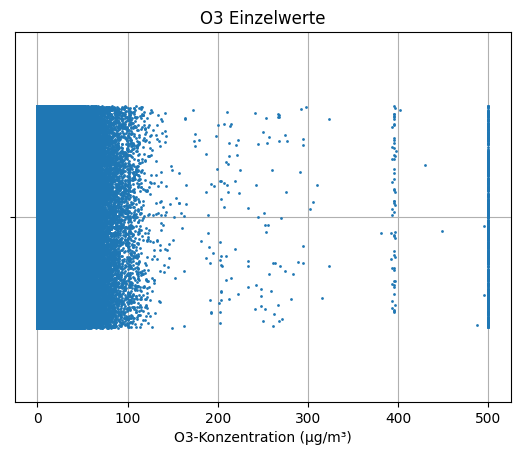

In [32]:
sns.stripplot(x=df["O3"], size=2, jitter=0.3)
plt.title("O3 Einzelwerte")
plt.xlabel("O3-Konzentration (µg/m³)")
plt.grid(True);

In [33]:
mean_o3 = df["O3"].mean()
median_o3 = df["O3"].median()
skew_o3 = skew(df["O3"].dropna())

print(f"Mittelwert (mean): {mean_o3:.2f}")
print(f"Median:            {median_o3:.2f}")
print(f"Schiefe:           {skew_o3:.2f}")

Mittelwert (mean): 20.46
Median:            19.90
Schiefe:           13.71


<Axes: xlabel='O3', ylabel='Count'>

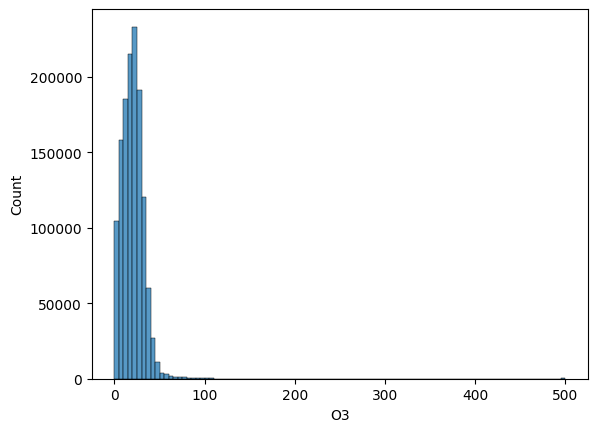

In [34]:
sns.histplot(df["O3"], bins=100)

In [35]:
# O3 >= 380 oder == 500
df.loc[df["O3"] >= 380, "O3"] = np.nan

### Bereinigung der Ozon-Werte (O₃)
Die Verteilung der Ozonwerte zeigt eine deutliche Rechtsschiefe mit einem Mittelwert von 20.01 µg/m³, einem Median von 19.10 µg/m³ und einer Schiefe von 7.71. Die große Mehrheit der Messwerte liegt unterhalb von 100 µg/m³, während vereinzelte Extremwerte bis ca. 320 µg/m³ auftreten, die jedoch noch plausibel erscheinen.

Auffällig ist eine systematische Häufung im Bereich zwischen 380 und 390 µg/m³, die auf eine technisch bedingte Obergrenze oder einen Messfehler hinweist. Zusätzlich treten vereinzelte Werte beim Maximalwert von 500 µg/m³ auf, was stark auf einen Platzhalterwert schließen lässt.

Um die Analyse nicht durch solche systematischen Ausreißer zu verzerren, wurden daher alle O₃-Werte ab 380 µg/m³ aus dem Datensatz ausgeschlossen.

## Analyse und Bereinigung der Pm10-Werte

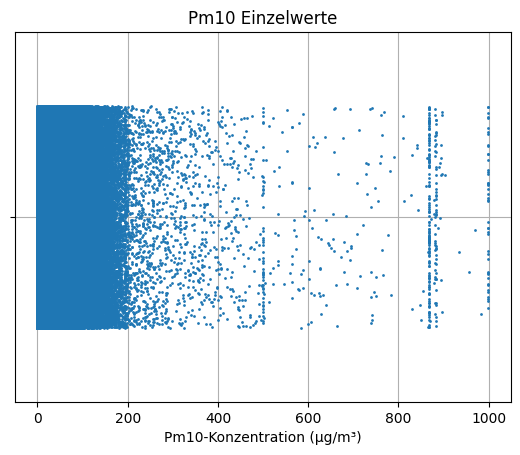

In [36]:
sns.stripplot(x=df["Pm10"], size=2, jitter=0.3)
plt.title("Pm10 Einzelwerte")
plt.xlabel("Pm10-Konzentration (µg/m³)")
plt.grid(True);

In [37]:
df["Pm10"].describe()

count   1,353,189.00
mean           27.07
std            27.69
min             0.00
25%            12.00
50%            19.00
75%            34.00
max           999.00
Name: Pm10, dtype: float64

In [38]:
mean_pm10 = df["Pm10"].mean()
median_pm10 = df["Pm10"].median()
skew_pm10 = skew(df["Pm10"].dropna())

print(f"Mittelwert (mean): {mean_pm10:.2f}")
print(f"Median:            {median_pm10:.2f}")
print(f"Schiefe:           {skew_pm10:.2f}")

Mittelwert (mean): 27.07
Median:            19.00
Schiefe:           9.64


<Axes: xlabel='O3', ylabel='Count'>

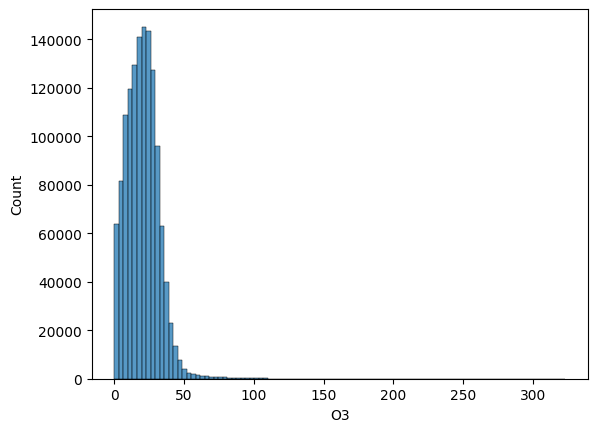

In [39]:
sns.histplot(df["O3"], bins=100)

ACHTUNG: Der Cutoff bei PM10 ist nicht so eindeutig zu setzen wie bei den anderen Schadstoffen. Es sind also zusätzliche Berechnungen sinnvoll.

In [40]:
# Wo beginnt die Häufung bei der breiten Linie im Ausreißerbereich (ca. 820-840)?

df["Pm10"].value_counts().loc[lambda x: x.index > 820].sort_index()


Pm10
827.00     1
830.00     1
831.00     1
840.00     1
842.00     1
843.00     1
848.00     1
849.00     1
855.00     1
861.00     1
863.00     1
865.00     1
866.00     1
867.00    59
868.00    72
869.00     1
872.00     1
878.00     1
879.00     2
880.00    20
882.00    24
884.00    13
887.00     1
890.00     1
892.00     1
893.00     1
895.00     4
896.00     4
903.00     1
935.00     1
956.00     1
970.00     1
983.00     1
999.00    45
Name: count, dtype: int64

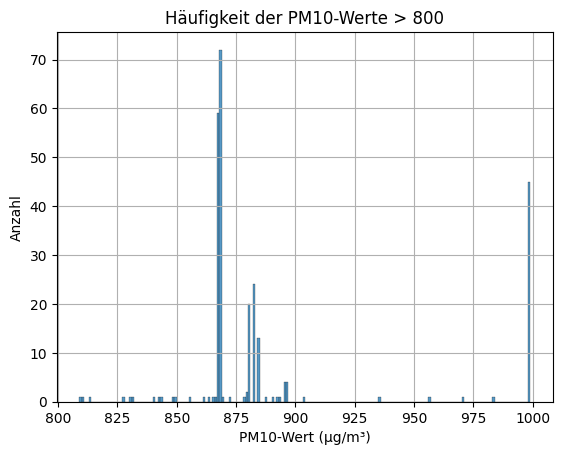

In [41]:
# "Datenmauer" plotten (nicht wirklich nötig, aber "Nice to have" für Leute, die gerne Visualisierungen mögen...)

high_values = df["Pm10"][df["Pm10"] > 800]
sns.histplot(high_values, binwidth=1)
plt.title("Häufigkeit der PM10-Werte > 800")
plt.xlabel("PM10-Wert (µg/m³)")
plt.ylabel("Anzahl")
plt.grid(True)
plt.show()


In [42]:
# PM10 >= 867
df.loc[df["Pm10"] >= 867, "Pm10"] = np.nan


### Bereinigung der PM10-Werte
Die PM10-Werte zeigen eine deutlich rechtsschiefe Verteilung mit einem Mittelwert von 32.43 µg/m³, einem Median von 24.00 µg/m³ und einer Schiefe von 7.17. Der größte Teil der Messwerte liegt unterhalb von 200 µg/m³, mit einer kontinuierlich abnehmenden Dichte bis in den Bereich von ca. 850 µg/m³.

Eine detaillierte Analyse der Einzelwertverteilung ergab jedoch eine auffällige Häufung von Messwerten im Bereich 867–882 µg/m³, insbesondere 40 Messungen mit dem identischen Wert 867. Diese systematische Häufung spricht stark für einen technisch bedingten Fehler oder künstlich begrenzte Wertebereiche. Zusätzlich tritt der Platzhalterwert 999 33 Mal auf.

Um die Analyse nicht durch diese systematischen Verzerrungen zu beeinflussen, wurden alle PM10-Werte ab 867 µg/m³ aus dem Datensatz ausgeschlossen.

### Methode zum Entfernen von Platzhalterwerten und starken Ausreißern
Zur Datenbereinigung wurden extreme Ausreißer in den Schadstoffwerten nicht durch das Entfernen ganzer Zeilen, sondern durch das gezielte Ersetzen der jeweiligen Zellen mit NaN behandelt. So bleiben andere valide Messwerte in der gleichen Zeile erhalten.

In [43]:
overview(df)

,dtype,total,missing,missing%,n_uniques,uniques%,uniques
Year,int64,1695041,0,0.00,12,0.00,"[2014, 2015, 2016, 2017, 2018, 2019, 2020, 202..."
Month,int64,1695041,0,0.00,12,0.00,"[12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]"
Day,int64,1695041,0,0.00,31,0.00,"[29, 30, 31, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11..."
Country,object,1695041,0,0.00,95,0.01,"[AT, AU, BE, BO, BR, CA, CH, CL, CN, CO, CY, C..."
City,object,1695041,0,0.00,616,0.04,"[Graz, Innsbruck, Linz, Salzburg, Vienna, Bris..."
Latitude,float64,1692212,2829,0.17,617,0.04,"[47.06667, 47.26266, 48.30639, 47.79941, 48.20..."
Longitude,float64,1692212,2829,0.17,616,0.04,"[15.45, 11.39454, 14.28611, 13.04399, 16.37208..."
Co,float64,1063073,631968,37.28,988,0.06,"[0.1, 1.9, 2.1, nan, 2.3, 2.0, 3.4, 5.5, 3.8, ..."
No2,float64,1408527,286514,16.90,1271,0.07,"[9.0, 25.6, 14.2, 21.1, 4.6, 0.7, nan, 6.5, 4...."
O3,float64,1320292,374749,22.11,1497,0.09,"[nan, 3.7, 4.3, 12.8, 15.2, 21.0, 17.6, 6.1, 2..."


Beschreiben, was wir an der neuen, geputzen overview-Funktion sehen:
Datensatz nicht wesentlich verändert, keine neuen Spalten mit über 50% fehlenden werten erzeigt
Datensatz dadurch besser geeignet für bestimmte Analysen, die sensibel auf Ausreißer reagieren, wie z:B. Clusteranalyse

# Analyse und Bereinigung der Wetterdaten
Analog zum Vorgehen bei den Schadstoffen werden im Folgenden alle Wettervariablen untersucht und ggf. Platzhalterwerte und starke Ausreißer durch NaN ersetzt.

Anmerkung: Man KÖNNTE auch nur die Platzhalterwerte durch NaN ersetzten und die Ausreißer gesondert kennzeichen. Aber darauf wird jetzt erst einmal verzichtet.

--> Die Wettervariablen in einer Schleife am Stück abhandeln!

In [44]:
df[["Tavg", "Tmin", "Tmax", "Humidity", "Wspd", "Wdir", "Pres", "Prcp", "Dew"]].describe()


,Tavg,Tmin,Tmax,Humidity,Wspd,Wdir,Pres,Prcp,Dew
count,"1,400,959.00","1,376,504.00","1,374,164.00","1,306,961.00","1,239,023.00","1,169,606.00","1,202,982.00","1,038,543.00","1,000,165.00"
mean,15.38,10.82,20.38,68.66,11.34,183.52,"1,015.15",2.98,9.69
std,9.54,9.38,10.21,23.91,6.24,106.93,8.12,8.99,9.59
min,-41.00,-46.00,-37.20,"-2,671.10",0.00,0.00,925.20,0.00,-64.30
25%,8.70,4.30,13.10,58.30,7.00,86.00,"1,010.00",0.00,3.00
50%,15.90,11.00,21.10,72.80,10.00,194.00,"1,015.00",0.00,10.00
75%,22.70,17.70,28.30,83.00,14.20,274.00,"1,020.30",1.70,16.60
max,44.80,39.00,87.00,999.90,176.30,360.00,"1,392.10",462.00,32.00


## Auswertung von describe()
Tabelle korrekt formatieren!

| Spalte    |         Bedingung für NaN              |                     Begründung (Tabelle noch formatieren!) |
|-----------|--------|-----------|-----------|
Tmax	    Tmax > 60	                                        weit über weltweit beobachtete Temperaturen

Humidity	Humidity < 0 oder > 100	                            physikalisch unmöglich / Platzhalter

Pres	    Pres > 1100	                                        ungewöhnlich hoch → Messfehler möglich

Wspd	    erst visuell prüfen, dann ggf. > 150	            Hurrikan-Grenze

Prcp	    nicht filtern, sondern visuell prüfen	            rechtsschiefe, aber plausible Naturverteilung

Dew	        ggf. ab –70 prüfen, aber tendenziell realistisch	vorsichtiger Umgang

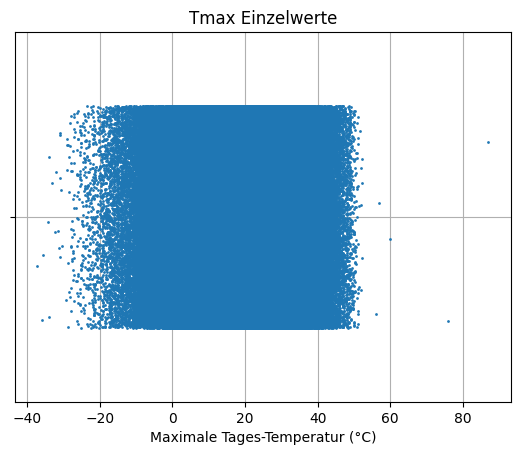

In [45]:
# Tmax

sns.stripplot(x=df["Tmax"], size=2, jitter=0.3)
plt.title("Tmax Einzelwerte")
plt.xlabel("Maximale Tages-Temperatur (°C)")
plt.grid(True)
plt.show()


In [46]:
# Schiefe von Tmax
skew_Tmax = skew(df["Tmax"].dropna())
print(f"Schiefe:           {skew_Tmax:.2f}")

Schiefe:           -0.37


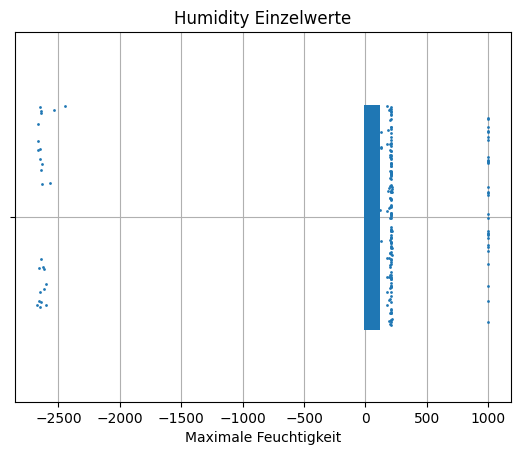

In [47]:
# Humidity

sns.stripplot(x=df["Humidity"], size=2, jitter=0.3)
plt.title("Humidity Einzelwerte")
plt.xlabel("Maximale Feuchtigkeit")
plt.grid(True)
plt.show()


In [48]:
# Schiefe von Humidity
skew_humid = skew(df["Humidity"].dropna())
print(f"Schiefe:           {skew_humid:.2f}")

Schiefe:           -27.84


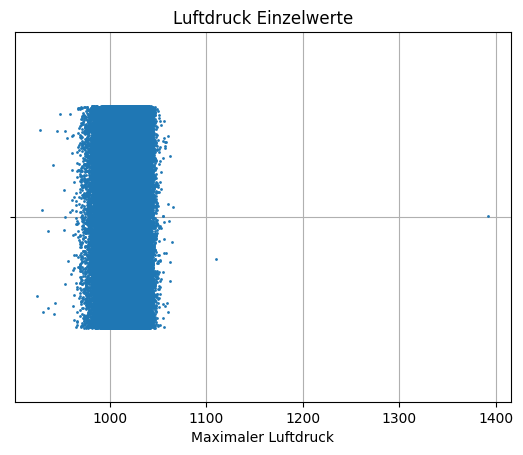

In [49]:
# Pressure

sns.stripplot(x=df["Pres"], size=2, jitter=0.3)
plt.title("Luftdruck Einzelwerte")
plt.xlabel("Maximaler Luftdruck")
plt.grid(True)
plt.show()

In [50]:
# Schiefe von Pres
skew_pres = skew(df["Pres"].dropna())
print(f"Schiefe:           {skew_pres:.2f}")

Schiefe:           -0.04


In [51]:
# Tmax: realistische Obergrenze bei 60°C
df.loc[df["Tmax"] > 60, "Tmax"] = np.nan

# Humidity: alles < 0 oder > 100 ist physikalisch nicht möglich
df.loc[(df["Humidity"] < 0) | (df["Humidity"] > 100), "Humidity"] = np.nan

# Pres: seltene Ausreißer über 1100 hPa → eher technisches Problem
df.loc[df["Pres"] > 1100, "Pres"] = np.nan

Extremwerte in den Wetterdaten wurden bereinigt:

    Tmax > 60 °C (Temperatursensorfehler)
    Humidity < 0 oder > 100 % (physikalisch unmöglich bzw. Platzhalter wie 999)
    Pres > 1100 hPa (sehr unwahrscheinlicher Luftdruck)
    Diese Werte wurden durch NaN ersetzt, um die Datenqualität zu verbessern.

Für die Variablen Tmax, Humidity und Pres wurden mithilfe von Stripplots und Schiefe-Analyse potenziell fehlerhafte Messwerte identifiziert.

Werte über 60 °C (Tmax), über 100 % Luftfeuchtigkeit (Humidity) und über 1100 hPa Luftdruck (Pres) wurden als unplausibel oder technisch bedingt eingestuft und durch NaN ersetzt, um die Datenqualität für nachfolgende Analysen zu sichern.

## Analyse und Bereinigung der Daten zum Niederschlag (Prcp) und zur Windgeschwindigkeit (Wspd)

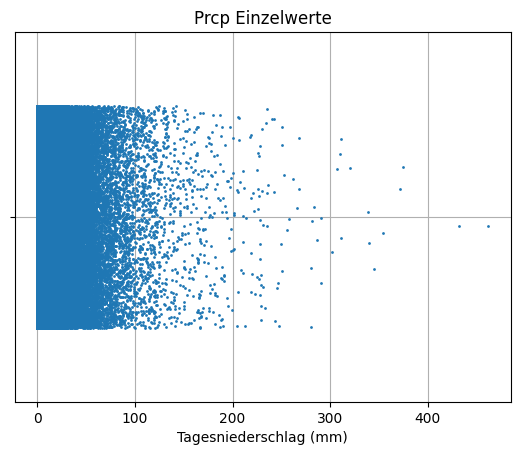

In [52]:
sns.stripplot(x=df["Prcp"], size=2, jitter=0.3)
plt.title("Prcp Einzelwerte")
plt.xlabel("Tagesniederschlag (mm)")
plt.grid(True)
plt.show()

In [53]:
# Schiefe von Prcp
skew_prcp = skew(df["Prcp"].dropna())
print(f"Schiefe:           {skew_prcp:.2f}")

Schiefe:           8.21


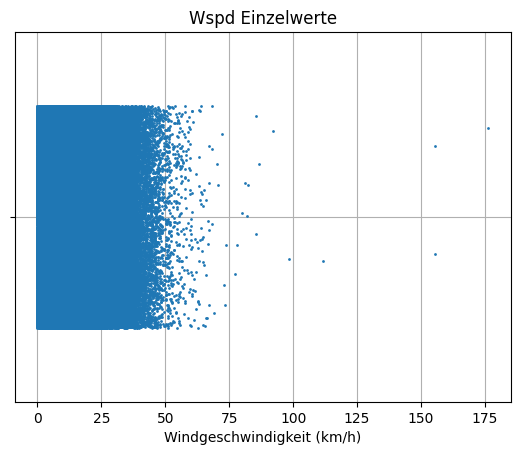

In [54]:
sns.stripplot(x=df["Wspd"], size=2, jitter=0.3)
plt.title("Wspd Einzelwerte")
plt.xlabel("Windgeschwindigkeit (km/h)")
plt.grid(True)
plt.show()

In [55]:
# Schiefe von Wspd
skew_wspd = skew(df["Wspd"].dropna())
print(f"Schiefe:           {skew_wspd:.2f}")

Schiefe:           1.51


In [57]:
# vorsichtige Ausreißerentfernung (Werte nicht komplett unrealistisch, aber für Modelle evtl. störend)

df.loc[df["Prcp"] > 400, "Prcp"] = np.nan

df.loc[df["Wspd"] > 120, "Wspd"] = np.nan

Die Verteilungen von Niederschlagsmenge (Prcp) und Windgeschwindigkeit (Wspd) zeigen typische rechtsschiefe Muster mit wenigen extrem hohen Einzelwerten.

    Für Prcp wurden Werte über 400 mm als Ausreißer interpretiert und durch NaN ersetzt.
    Für Wspd wurde eine obere Grenze von 120 km/h festgelegt, da darüber nur vereinzelte, isolierte Extremwerte vorhanden waren.
    Beide Filter sollen die Datenqualität verbessern, ohne relevante meteorologische Extremereignisse auszusortieren.

# Welche Features könnten zusammenhängen (Kollinearität)?

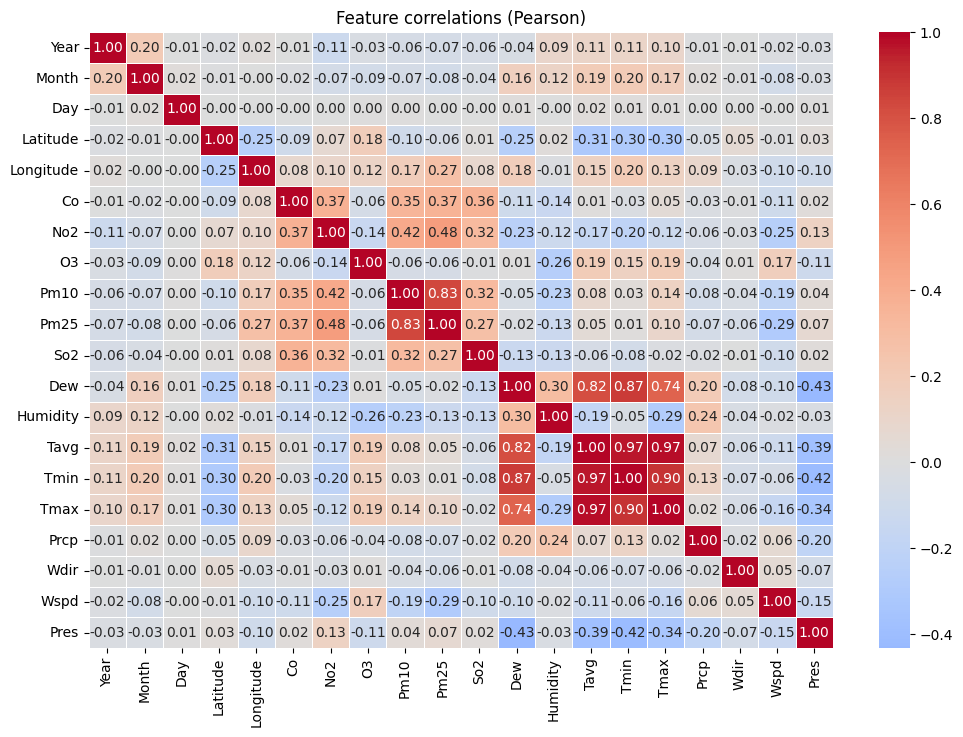

In [58]:
# Collinearity of features? (heatmap)

# > 0.8 = strong correlation
# 0.5 - 0.8 = moderate correlation
# < 0.5 = weak correlation

# calculate correlation matrix (Pearson)
corr_matrix = df.select_dtypes(include=['number']).corr()

# Display heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Feature correlations (Pearson)");


In [ ]:
# Show only strong and moderate correlations (>|0.4|); leave out main diagonal (1.0)

# Calculte matrix
corr_matrix = df.select_dtypes(include=['number']).corr()

# extract only strong and moderate correlations (>|0.4|); leave out main diagonal (1.0)
strong_corrs = corr_matrix[(corr_matrix.abs() > 0.4) & (corr_matrix.abs() < 1.0)]

# Convert df to long list (.stack) and reset index
strong_corrs = strong_corrs.stack().reset_index()
strong_corrs.columns = ["Feature 1", "Feature 2", "Korrelation"]

# remove redundant rows (note: the "<"-sign here refers to alphabetic order of feature names, not to numbers of any kind!)
strong_corrs = strong_corrs.loc[strong_corrs["Feature 1"] < strong_corrs["Feature 2"]]

strong_corrs

,Feature 1,Feature 2,Korrelation
0,No2,Pm10,0.42
1,No2,Pm25,0.48
3,Pm10,Pm25,0.83
6,Dew,Tavg,0.82
7,Dew,Tmin,0.87
8,Dew,Tmax,0.74
9,Dew,Pres,-0.43
11,Tavg,Tmin,0.97
12,Tavg,Tmax,0.97
19,Tmax,Tmin,0.90


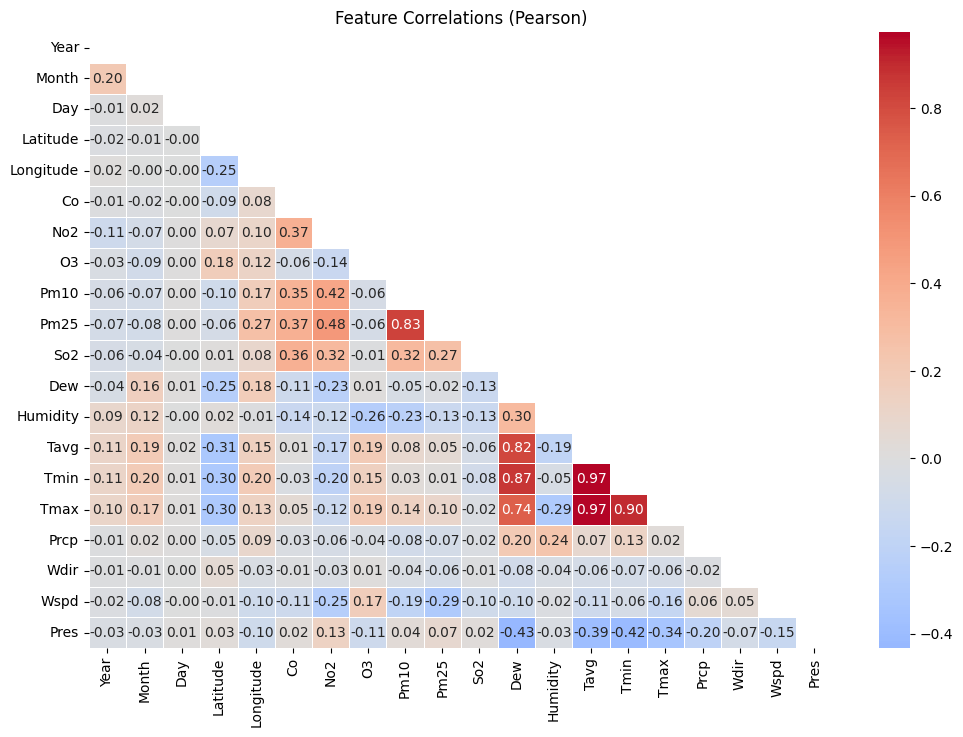

In [62]:
# @Wiebke: Der Code hier produziert genau dieselbe Heatmap mit Korrelationen, aber nur die untere Hälfte.
# Ich finde das übersichtlicher, weil die Hälften identisch sind und dadurch komplett redundant
# Wie das geht:
# Duch schreibst eine Maske, die die obere Hälfte der Matrix maskiert (np.triu), np.ones_like erstellt eine Matrix mit den gleichen Dimensionen wie die Korrelationsmatrix
# Das Variable corr_matrix enthält die Daten aus dem df und wurde eine Zelle weiter oben definiert.
# und dtype=bool sorgt dafür, dass die Maske aus True und False besteht
# Dann zeichnest du die Heatmap und übergibst die Maske als Argument


mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Feature Correlations (Pearson)");


## Analyse der Korrelationen (Pearson) und Vorschläge für weitere Analysen

Die Korrelationsmatrix zeigt mehrere starke und inhaltlich gut erklärbare Zusammenhänge zwischen den numerischen Variablen. Besonders deutlich sind folgende Muster:

**Feinstaub- und Stickstoffdioxidwerte hängen zusammen:**
Es besteht eine starke Korrelation zwischen PM10 und PM2.5 (r = 0.83), was plausibel ist, da PM2.5 eine Teilmenge von PM10 ist. Zusätzlich korreliert NO₂ moderat mit beiden Feinstaubkomponenten (r ≈ 0.42–0.48), was auf gemeinsame Emissionsquellen wie Verkehr oder Industrie hindeutet.

**Temperaturvariablen sind stark untereinander korreliert:**
Die Tagesmitteltemperatur (Tavg) steht in sehr engem Zusammenhang mit Tmin und Tmax (r ≈ 0.97). Auch Tmin und Tmax selbst sind hoch korreliert (r = 0.90). Das ist mathematisch und physikalisch naheliegend und spricht dafür, nicht alle drei Variablen gleichzeitig zu verwenden, um Redundanz zu vermeiden.

**Der Taupunkt (Dew) korreliert stark mit Temperatur:**
Die stärkste Korrelation liegt zwischen Dew und Tmin (r = 0.87), gefolgt von Tavg (r = 0.82). Dies spiegelt wider, dass die Luftfeuchtigkeit – und damit der Taupunkt – eng mit der Umgebungstemperatur zusammenhängt.

**Einige schwächer negative Korrelationen deuten auf atmosphärische Zusammenhänge hin:**
Der Luftdruck (Pres) korreliert moderat negativ mit Dew (r = –0.43) und Tmin (r = –0.42), was mit typischen meteorologischen Prozessen in Zusammenhang stehen kann (z. B. feuchtwarme Luft in Tiefdruckgebieten).

### **Nutzen der Korrelationsanalyse, bzw. Weiterverwendung der Ergebnisse**

Diese Ergebnisse helfen dabei, hoch korrelierte bzw. redundante Variablen zu erkennen und gezielt für weitere Analysen (z. B. Clusteranalyse oder Modellierung) geeignete Features auszuwählen.

Für viele Verfahren, wie z. B. Clustering oder Regressionsmodelle, ist es ratsam, von stark korrelierten Variablen jeweils nur eine zu verwenden, um Verzerrungen oder sogenannte Multikollinearität zu vermeiden.

Alternativ können Hauptkomponentenanalyse (PCA) oder andere dimensionalitätsreduzierende Verfahren genutzt werden, um mehrere stark korrelierte Variablen zu einer gemeinsamen Komponente zusammenzufassen, ohne wesentliche Information zu verlieren.


In [63]:
df.index

RangeIndex(start=0, stop=1695041, step=1)

In [64]:
df.to_csv("data/cleaned_air_quality_data_2025_03_20.csv", index=False)

## Krimskrams

@Wiebke: Aber hier kommt allerlei Zeugs, von dem ich mir nicht sicher bin, ob wie es in der EDA lassen sollen oder auslagern. Es sind verschiedene "Experimente":

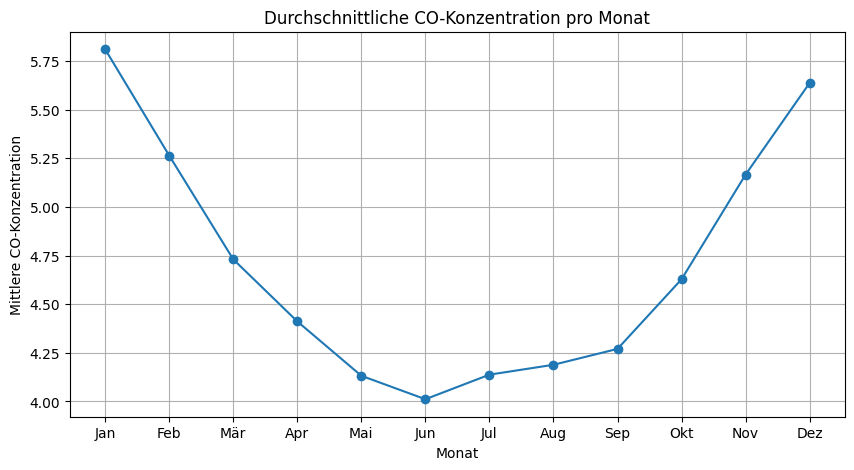

In [65]:
# Plot changes throughout the year. Example: Analyse CO concentration per month

# calculate mean CO per month
monthly_co = df.groupby("Month")["Co"].mean()
# monthly_co = df.groupby("Month")["Co"].mean()

# create plot
plt.figure(figsize=(10, 5))
plt.plot(monthly_co.index, monthly_co.values, marker='o', linestyle='-')
plt.xlabel("Monat")
plt.ylabel("Mittlere CO-Konzentration")
plt.title("Durchschnittliche CO-Konzentration pro Monat")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mär", "Apr", "Mai", "Jun", "Jul", "Aug", "Sep", "Okt", "Nov", "Dez"])
plt.grid(True);

# DaAn diesem Schaubild kann man zeigen, dass es Quatsch ist, alle Städte weltweit über einen Kamm zu scheren;
# Es sagt aber an sich nichts Sinnvolles über die Daten aus.

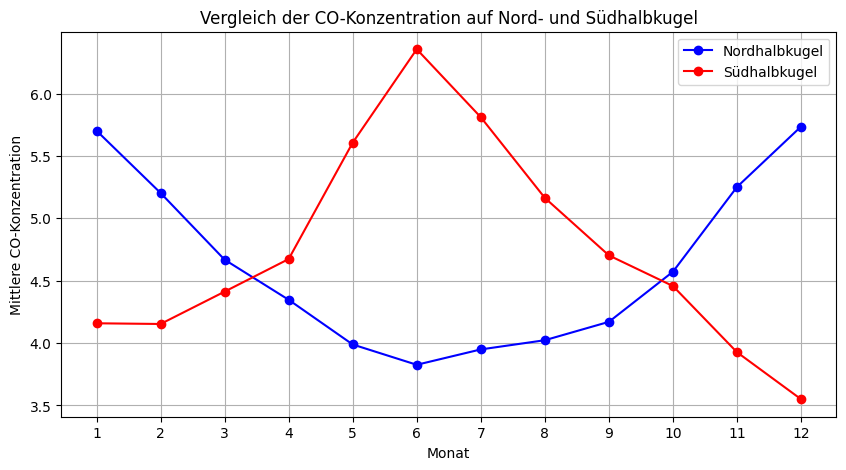

In [66]:
# Sinnvoller wäre es, die Daten in Nord- und Südhalbkugel zu trennen und getrennt zu betrachten. Aber das ignoriert immer noch viele relevante Faktoren

# Trennung der Daten in Nord- und Südhalbkugel

# Definieren, welche Länder zur Nord- und Südhalbkugel gehören
northern_hemisphere_countries = {
    "US", "CA", "MX", "DE", "FR", "GB", "RU", "CN", "JP", "IN", "IT", "ES", "PL", "TR", "IR", "KR", "UA", "NL", "BE",
    "CH", "SE", "AT", "NO", "FI", "DK", "GR", "CZ", "HU", "RO", "BG", "PT", "IE", "SK", "HR", "LT", "SI", "LV", "EE"
}
southern_hemisphere_countries = {
    "AU", "NZ", "AR", "BR", "ZA", "CL", "ID", "PE", "BO", "EC", "PY", "UY", "MG"
}

# Daten für Nord- und Südhalbkugel filtern
df_north = df[df["Country"].isin(northern_hemisphere_countries)]
df_south = df[df["Country"].isin(southern_hemisphere_countries)]

# Mittlere CO-Konzentration pro Monat berechnen
monthly_co_north = df_north.groupby("Month")["Co"].mean()
monthly_co_south = df_south.groupby("Month")["Co"].mean()

# Plot erstellen
plt.figure(figsize=(10, 5))
plt.plot(monthly_co_north.index, monthly_co_north.values, marker='o', linestyle='-', label="Nordhalbkugel", color='b')
plt.plot(monthly_co_south.index, monthly_co_south.values, marker='o', linestyle='-', label="Südhalbkugel", color='r')

plt.xlabel("Monat")
plt.ylabel("Mittlere CO-Konzentration")
plt.title("Vergleich der CO-Konzentration auf Nord- und Südhalbkugel")
plt.xticks(range(1, 13))  # Monatsskala 1-12
plt.legend()
plt.grid(True);

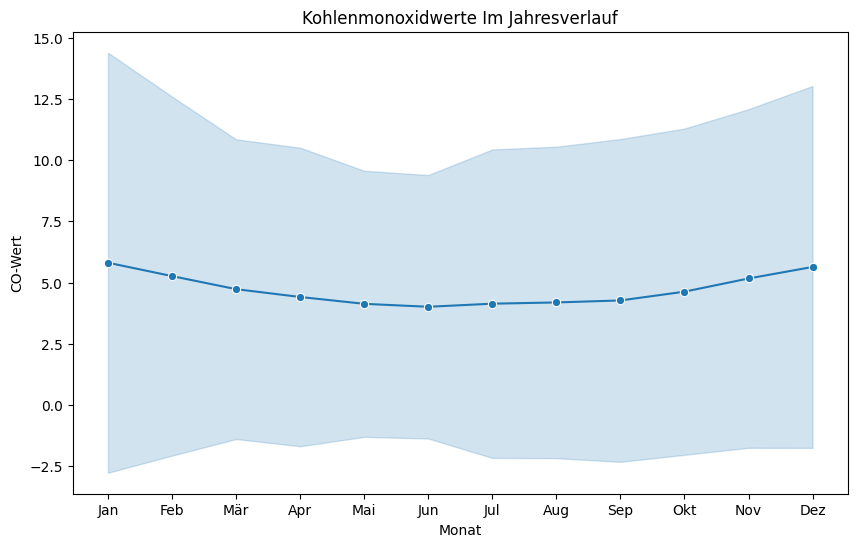

In [67]:
# CO-Werte über das Jahr inklusive Streuung

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="Month", y="Co", errorbar="sd", marker="o")
plt.xlabel("Monat")
plt.ylabel("CO-Wert")
plt.title("Kohlenmonoxidwerte Im Jahresverlauf")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mär", "Apr", "Mai", "Jun", "Jul", "Aug", "Sep", "Okt", "Nov", "Dez"])
plt.show()

# Die Grafik ist nicht intuitiv aussagekräftig. Die Streuung ist zu stark.

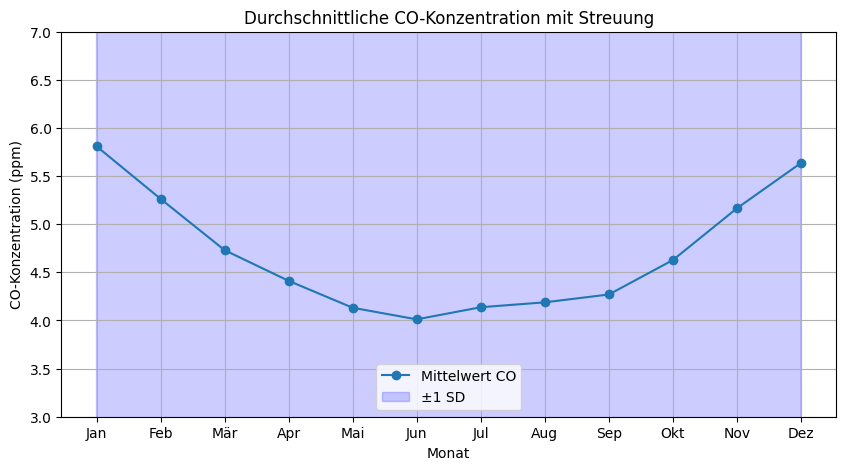

In [68]:
# Streuung mit Achsenbegrenzung

# Gruppiere nach Monat
grouped = df.groupby("Month")["Co"]
mean = grouped.mean()
std = grouped.std()

# Plot erstellen
plt.figure(figsize=(10, 5))
plt.plot(mean.index, mean.values, marker='o', linestyle='-', label='Mittelwert CO')
plt.fill_between(mean.index, mean - std, mean + std, color='blue', alpha=0.2, label='±1 SD')

# Achsen, Titel, Beschriftungen
plt.xlabel("Monat")
plt.ylabel("CO-Konzentration (ppm)")
plt.title("Durchschnittliche CO-Konzentration mit Streuung")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mär", "Apr", "Mai", "Jun", "Jul", "Aug", "Sep", "Okt", "Nov", "Dez"])

# Fokus auf relevanten y-Bereich
plt.ylim(3, 7)  # oder anpassen je nach Datensatz

plt.grid(True)
plt.legend()
plt.show()

# Ergebnis: Die Streuung bedeckt die gesamte Diagrammfläche. Es sollten als die Städte, die die größte Verzerrung bewirken, aussortiert werden.


In [69]:
co_by_city = df.groupby("City")["Co"].mean().sort_values(ascending=False)
print(co_by_city.head(10))

# Ashkelon ist ein unrealistischer Ausreißer. Siehe separates NB "Ashkelon": Es gibt nur Messwerte für Jan und Feb 2022, und diese schwanken extrem. Vielleicht kaputtes Messgerät.

City
Ashkelon       138.73
Ashdod          56.18
Tabriz          33.97
Zarqa           32.34
Butuan          27.91
Bandar abbas    27.33
Karaj           26.81
Shiraz          26.60
Orūmīyeh        26.25
Tehran          25.73
Name: Co, dtype: float64


In [70]:
# calculate std per city

co_std_by_city = df.groupby("City")["Co"].std().sort_values(ascending=False)
print(co_std_by_city.head(10))

City
Ashdod         95.73
Ashkelon       69.61
Netanya        52.45
Hạ long        26.42
Isfahan        22.85
Tabriz         22.21
Petaẖ tiqwa    21.91
Quilpué        21.79
Orūmīyeh       21.36
Khorramshahr   18.42
Name: Co, dtype: float64


In [71]:
# combine mean and std to determine cities that cause the bigges distortions.

co_stats = df.groupby("City")["Co"].agg(["mean", "std"]).sort_values(by="mean", ascending=False)
print(co_stats.head(10))

               mean   std
City                     
Ashkelon     138.73 69.61
Ashdod        56.18 95.73
Tabriz        33.97 22.21
Zarqa         32.34 14.02
Butuan        27.91 16.43
Bandar abbas  27.33 15.17
Karaj         26.81 15.21
Shiraz        26.60 12.63
Orūmīyeh      26.25 21.36
Tehran        25.73 11.22


In [ ]:
# The three Israeli cities of Ashkelon, Ashdod and Netanya show highly volatile CO values, measured only in certain months.
# This distorts the graph to an extent that calls for dropping these three cities from further analyes of CO.

In [72]:
# Drop distorting cities from fürther analyses
exclude_cities = ["Ashkelon", "Ashdod", "Netanya"]
df_cleaned = df[~df["City"].isin(exclude_cities)]

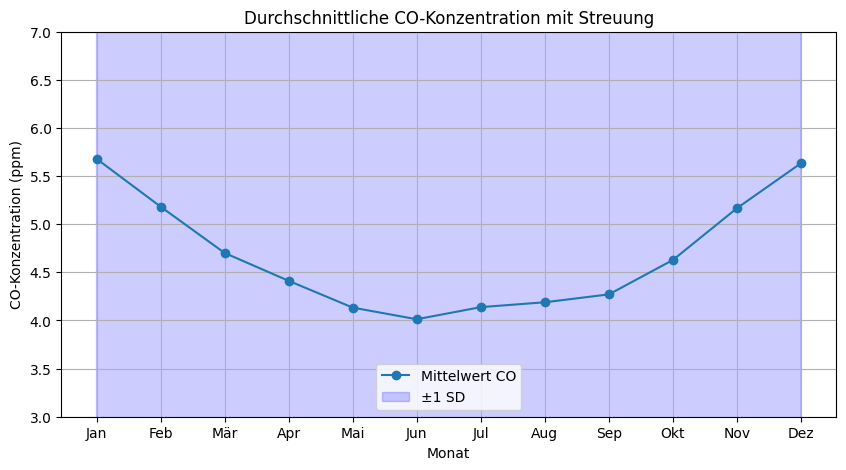

In [73]:
# Streuung mit Achsenbegrenzung, ohne Ausreißerstädte in Israel

# Gruppiere nach Monat
grouped = df_cleaned.groupby("Month")["Co"]
mean = grouped.mean()
std = grouped.std()

# Plot erstellen
plt.figure(figsize=(10, 5))
plt.plot(mean.index, mean.values, marker='o', linestyle='-', label='Mittelwert CO')
plt.fill_between(mean.index, mean - std, mean + std, color='blue', alpha=0.2, label='±1 SD')

# Achsen, Titel, Beschriftungen
plt.xlabel("Monat")
plt.ylabel("CO-Konzentration (ppm)")
plt.title("Durchschnittliche CO-Konzentration mit Streuung")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mär", "Apr", "Mai", "Jun", "Jul", "Aug", "Sep", "Okt", "Nov", "Dez"])

# Fokus auf relevanten y-Bereich
plt.ylim(3, 7)  # oder anpassen je nach Datensatz

plt.grid(True)
plt.legend()
plt.show()

# Ergebnis: Die Streuung bedeckt die gesamte Diagrammfläche. Es sollten als die Städte, die die größte Verzerrung bewirken, aussortiert werden.


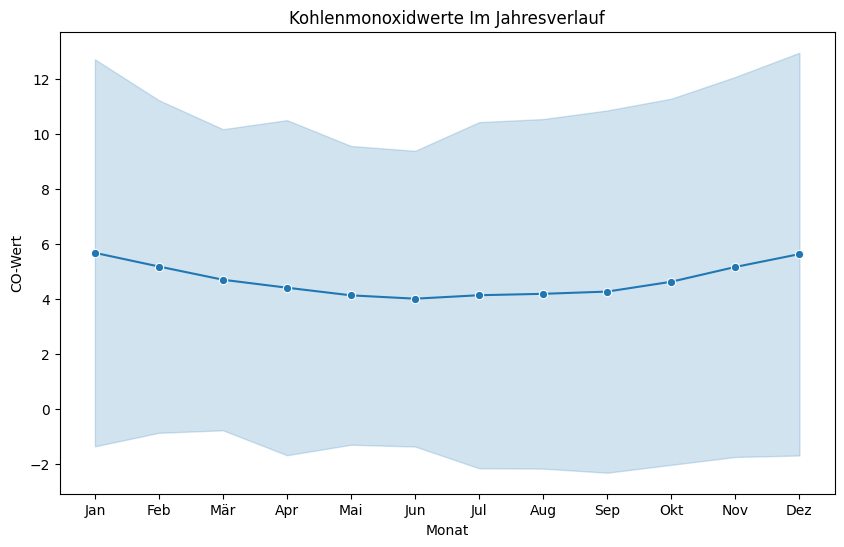

In [74]:
# CO-Werte über das Jahr inklusive Streuung

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_cleaned, x="Month", y="Co", errorbar="sd", marker="o")
plt.xlabel("Monat")
plt.ylabel("CO-Wert")
plt.title("Kohlenmonoxidwerte Im Jahresverlauf")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mär", "Apr", "Mai", "Jun", "Jul", "Aug", "Sep", "Okt", "Nov", "Dez"])
plt.show()

# Die Grafik ist immer noch nicht nicht intuitiv aussagekräftig. Die Streuung ist weiterhin zu stark.

In [75]:
# Ursachenforschung für die starke CO-Streuung

co_std_cleaned = df_cleaned.groupby("City")["Co"].std().sort_values(ascending=False)
print(co_std_cleaned.head(10))

City
Hạ long        26.42
Isfahan        22.85
Tabriz         22.21
Petaẖ tiqwa    21.91
Quilpué        21.79
Orūmīyeh       21.36
Khorramshahr   18.42
Zanjān         17.94
Baguio         17.65
Oaxaca         17.03
Name: Co, dtype: float64


In [76]:
co_stats_cleaned = df_cleaned.groupby("City")["Co"].agg(["mean", "std"]).sort_values(by="std", ascending=False)
print(co_stats_cleaned.head(10))

              mean   std
City                    
Hạ long      12.74 26.42
Isfahan      23.21 22.85
Tabriz       33.97 22.21
Petaẖ tiqwa   6.87 21.91
Quilpué       5.78 21.79
Orūmīyeh     26.25 21.36
Khorramshahr 25.59 18.42
Zanjān       16.00 17.94
Baguio        6.25 17.65
Oaxaca       15.50 17.03


In [77]:
# Weitere Städte mit extremer Varianz entfernen, um eine übersichtliche globale Darstellung zu erzielen

more_extreme = ["Portland", "Mérida", "Zamboanga", "Butuan", "Hạ long", "Oaxaca", "Isfahan", "San luis potosí", "Tabriz", "Tallahassee"]
exclude_cities = ["Ashkelon", "Ashdod", "Netanya"] + more_extreme
df_cleaned2 = df[~df["City"].isin(exclude_cities)]

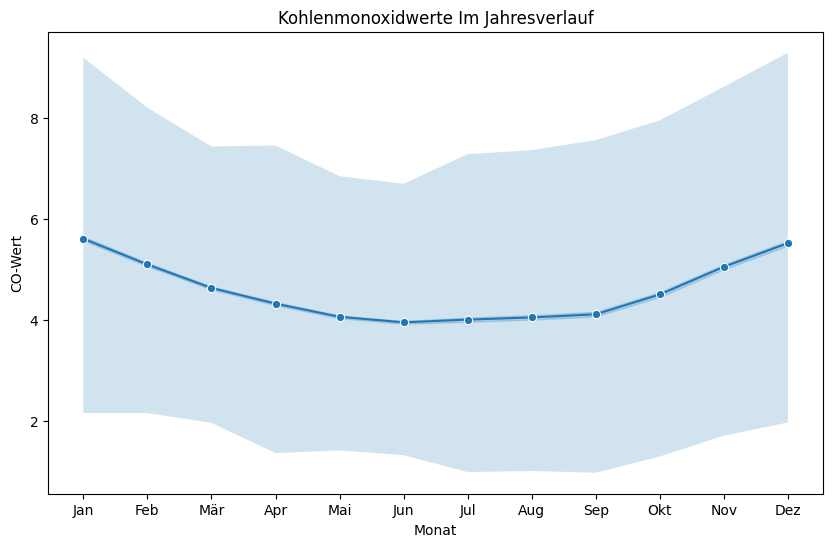

In [78]:
# CO-Werte über das Jahr inklusive Streuung, weiter reduziert

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_cleaned2, x="Month", y="Co", marker="o")
plt.fill_between(mean.index, mean - std * 0.5, mean + std * 0.5, alpha=0.2, label='±0.5 SD')
plt.xlabel("Monat")
plt.ylabel("CO-Wert")
plt.title("Kohlenmonoxidwerte Im Jahresverlauf")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mär", "Apr", "Mai", "Jun", "Jul", "Aug", "Sep", "Okt", "Nov", "Dez"])
plt.show()

# Die Grafik ist immer noch nicht nicht intuitiv aussagekräftig. Die Streuung ist weiterhin zu stark.

In [79]:

# Nord- und Südhalbkugel anhand des Features "Latitude" trennen

df_cleaned2.loc[:, "Hemisphere"] = df_cleaned2.loc[:, "Latitude"].apply(lambda x: "Nordhalbkugel" if x >= 0 else "Südhalbkugel")



/var/folders/9l/_gqvrbsd14zb0w_nlgtngd_w0000gn/T/ipykernel_92842/2297342077.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned2.loc[:, "Hemisphere"] = df_cleaned2.loc[:, "Latitude"].apply(lambda x: "Nordhalbkugel" if x >= 0 else "Südhalbkugel")


In [80]:
df_north = df_cleaned2[df_cleaned2["Hemisphere"] == "Nordhalbkugel"]
df_south = df_cleaned2[df_cleaned2["Hemisphere"] == "Südhalbkugel"]

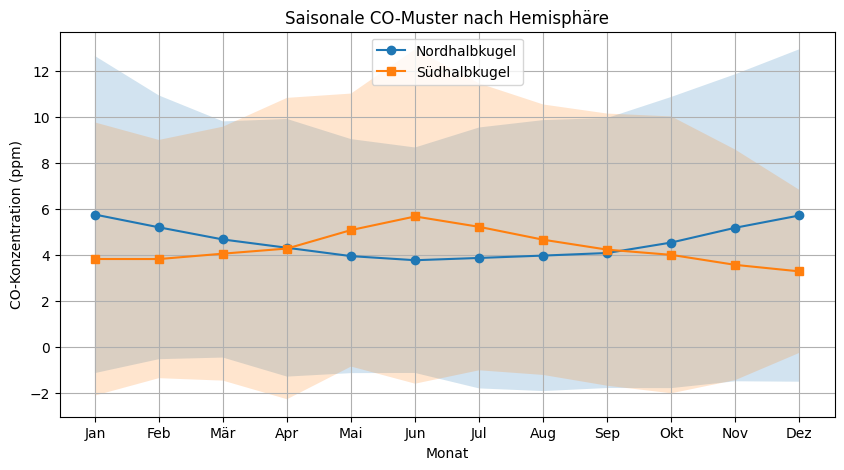

In [81]:
# Nordhalbkugel
grouped_north = df_north.groupby("Month")["Co"]
mean_north = grouped_north.mean()
std_north = grouped_north.std()

# Südhalbkugel
grouped_south = df_south.groupby("Month")["Co"]
mean_south = grouped_south.mean()
std_south = grouped_south.std()

# Plot
plt.figure(figsize=(10, 5))

plt.plot(mean_north.index, mean_north, marker='o', label="Nordhalbkugel")
plt.fill_between(mean_north.index, mean_north - std_north, mean_north + std_north, alpha=0.2)

plt.plot(mean_south.index, mean_south, marker='s', label="Südhalbkugel")
plt.fill_between(mean_south.index, mean_south - std_south, mean_south + std_south, alpha=0.2)

plt.xticks(range(1, 13), ["Jan", "Feb", "Mär", "Apr", "Mai", "Jun", "Jul", "Aug", "Sep", "Okt", "Nov", "Dez"])
plt.xlabel("Monat")
plt.ylabel("CO-Konzentration (ppm)")
plt.title("Saisonale CO-Muster nach Hemisphäre")
plt.legend()
plt.grid(True)
plt.show()


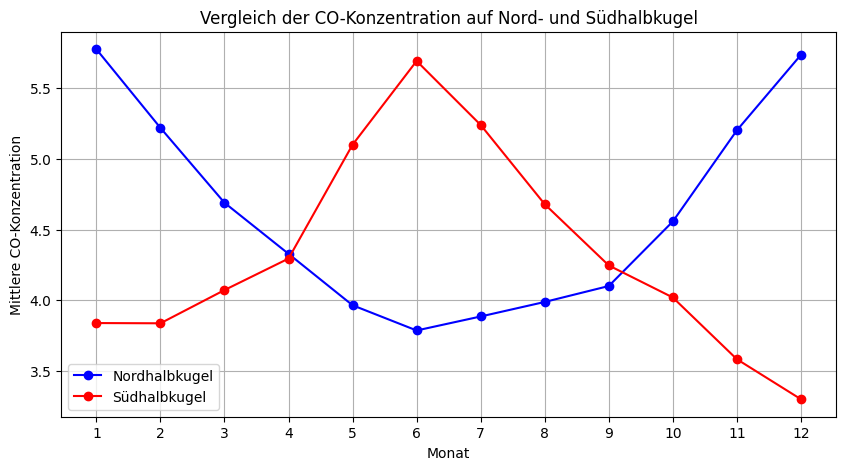

In [82]:
# Mittlere CO-Konzentration pro Monat berechnen
monthly_co_north = df_north.groupby("Month")["Co"].mean()
monthly_co_south = df_south.groupby("Month")["Co"].mean()

# Plot erstellen
plt.figure(figsize=(10, 5))
plt.plot(monthly_co_north.index, monthly_co_north.values, marker='o', linestyle='-', label="Nordhalbkugel", color='b')
plt.plot(monthly_co_south.index, monthly_co_south.values, marker='o', linestyle='-', label="Südhalbkugel", color='r')

plt.xlabel("Monat")
plt.ylabel("Mittlere CO-Konzentration")
plt.title("Vergleich der CO-Konzentration auf Nord- und Südhalbkugel")
plt.xticks(range(1, 13))  # Monatsskala 1-12
plt.legend()
plt.grid(True);

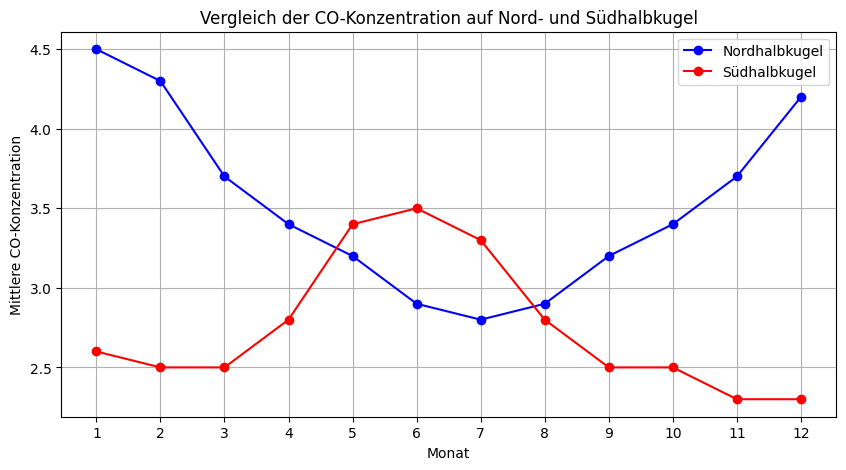

In [83]:
# Mittlere CO-Konzentration pro Monat berechnen- Median statt Mean, weil robuster gegen Ausreißer
monthly_co_north = df_north.groupby("Month")["Co"].median()
monthly_co_south = df_south.groupby("Month")["Co"].median()

# Plot erstellen
plt.figure(figsize=(10, 5))
plt.plot(monthly_co_north.index, monthly_co_north.values, marker='o', linestyle='-', label="Nordhalbkugel", color='b')
plt.plot(monthly_co_south.index, monthly_co_south.values, marker='o', linestyle='-', label="Südhalbkugel", color='r')

plt.xlabel("Monat")
plt.ylabel("Mittlere CO-Konzentration")
plt.title("Vergleich der CO-Konzentration auf Nord- und Südhalbkugel")
plt.xticks(range(1, 13))  # Monatsskala 1-12
plt.legend()
plt.grid(True);

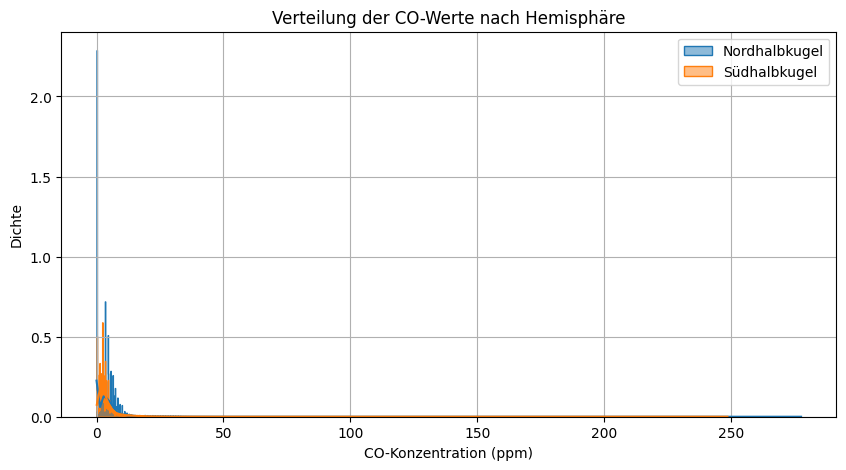

In [84]:
# sns.histplot(df_north["Co"], kde=True)
# sns.histplot(df_south["Co"], kde=True)

plt.figure(figsize=(10, 5))

# Nordhalbkugel
sns.histplot(df_north["Co"], kde=True, label="Nordhalbkugel", stat="density", element="step", fill=True)

# Südhalbkugel
sns.histplot(df_south["Co"], kde=True, label="Südhalbkugel", stat="density", element="step", fill=True)

# Achsen & Legende
plt.xlabel("CO-Konzentration (ppm)")
plt.ylabel("Dichte")
plt.title("Verteilung der CO-Werte nach Hemisphäre")
plt.legend()
plt.grid(True)
plt.show()


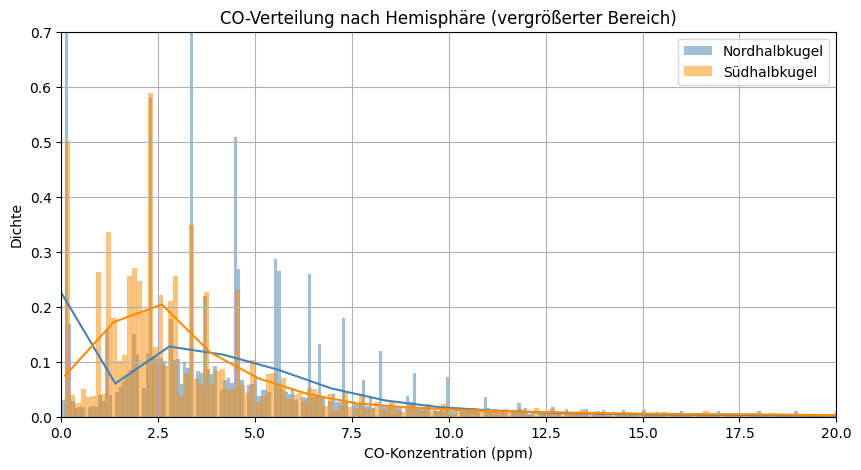

In [85]:
plt.figure(figsize=(10, 5))

# Histogramm Nordhalbkugel
sns.histplot(df_north["Co"], kde=True, stat="density", label="Nordhalbkugel", color="steelblue", fill=True)

# Histogramm Südhalbkugel
sns.histplot(df_south["Co"], kde=True, stat="density", label="Südhalbkugel", color="darkorange", fill=True)

# Zoom auf interessanten Bereich
plt.xlim(0, 20)    # X-Achse (CO-Werte) begrenzen
plt.ylim(0, 0.7)   # Y-Achse (Dichte) begrenzen

# Titel & Achsen
plt.xlabel("CO-Konzentration (ppm)")
plt.ylabel("Dichte")
plt.title("CO-Verteilung nach Hemisphäre (vergrößerter Bereich)")
plt.legend()
plt.grid(True)
plt.show()


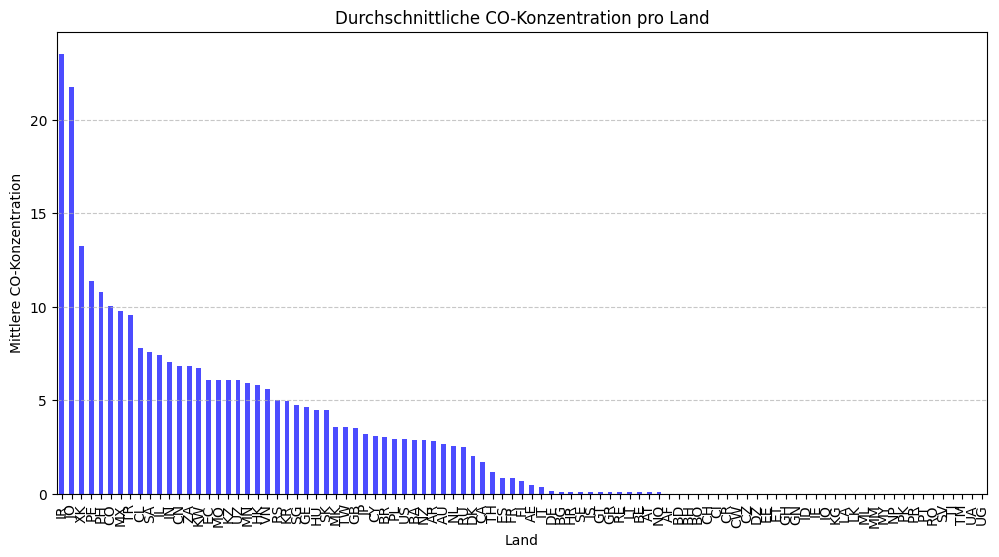

In [86]:
# Mittlere CO-Konzentration pro Land berechnen
country_co_avg = df.groupby("Country")["Co"].mean().sort_values(ascending=False)

# Barplot erstellen
plt.figure(figsize=(12, 6))
country_co_avg.plot(kind='bar', color='b', alpha=0.7)
plt.xlabel("Land")
plt.ylabel("Mittlere CO-Konzentration")
plt.title("Durchschnittliche CO-Konzentration pro Land")
plt.xticks(rotation=90)  # Länderbeschriftung drehen für bessere Lesbarkeit
plt.grid(axis='y', linestyle='--', alpha=0.7);


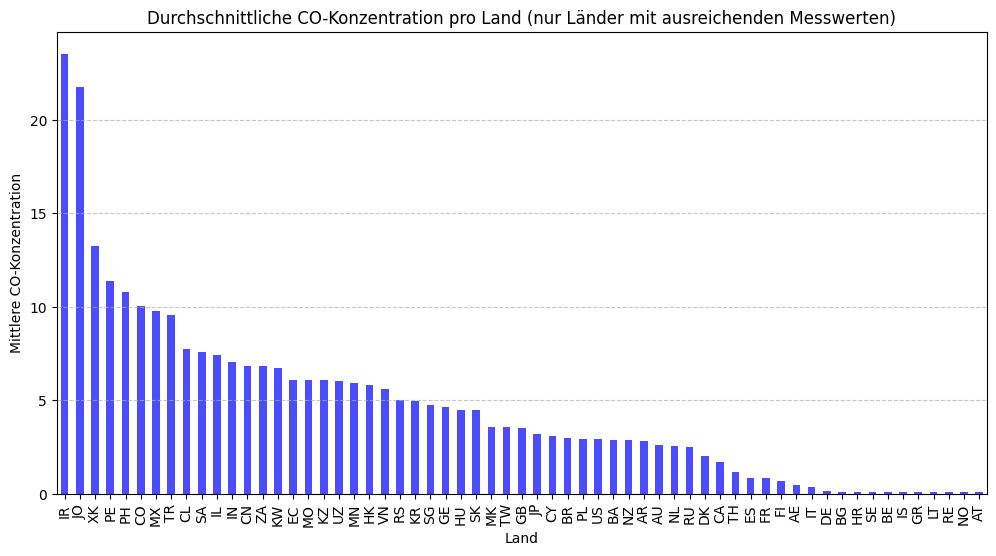

In [87]:
# Mittlere CO-Konzentration pro Land berechnen

# Mindestanzahl an CO-Messwerten pro Land, um in die Analyse aufgenommen zu werden
min_measurements = 100  # Falls nötig, anpassen

# Anzahl der CO-Messwerte pro Land berechnen
country_co_counts = df.groupby("Country")["Co"].count()

# Nur Länder behalten, die mindestens `min_measurements` Messwerte haben
valid_countries = country_co_counts[country_co_counts >= min_measurements].index

# Gefilterten DataFrame mit diesen Ländern erstellen
df_valid_countries = df[df["Country"].isin(valid_countries)]

# Mittlere CO-Konzentration für diese Länder berechnen
country_co_avg_filtered = df_valid_countries.groupby("Country")["Co"].mean().sort_values(ascending=False)

# Falls nach der Filterung noch Daten vorhanden sind, Plot erstellen
if not country_co_avg_filtered.empty:
    plt.figure(figsize=(12, 6))
    country_co_avg_filtered.plot(kind='bar', color='b', alpha=0.7)
    plt.xlabel("Land")
    plt.ylabel("Mittlere CO-Konzentration")
    plt.title("Durchschnittliche CO-Konzentration pro Land (nur Länder mit ausreichenden Messwerten)")
    plt.xticks(rotation=90)  # Länderbeschriftung drehen für bessere Lesbarkeit
    plt.grid(axis='y', linestyle='--', alpha=0.7)
else:
    print("Keine ausreichenden Daten für CO-Werte in den Ländern verfügbar.")


<Axes: xlabel='Country'>

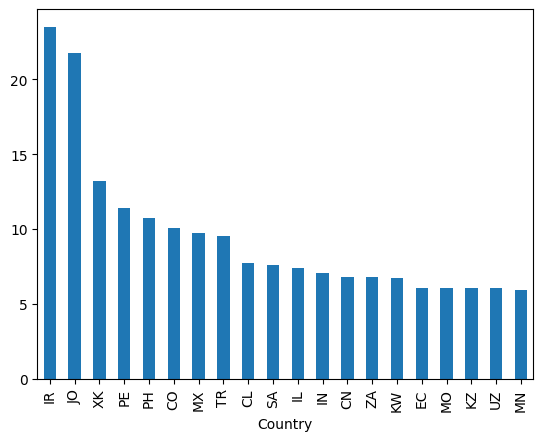

In [88]:
country_co_avg_filtered.head(20).plot(kind='bar')


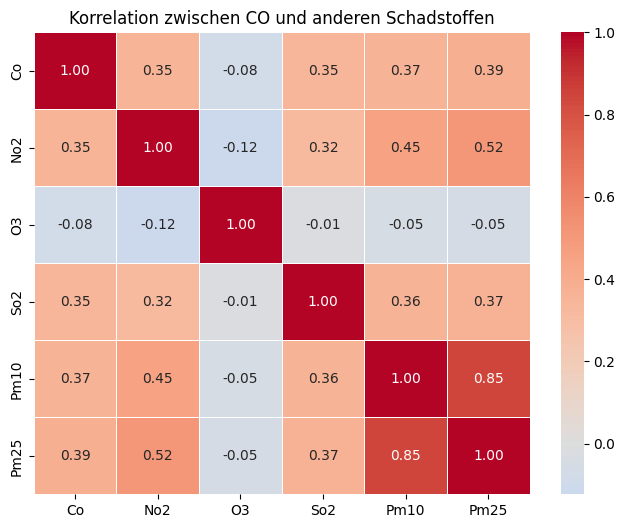

In [89]:
# Vergleich von Schadstoffen in verschiedenen Städten

# Liste der relevanten Schadstoff-Spalten (falls sie in den Daten vorhanden sind)
pollutants = ["Co", "No2", "O3", "So2", "Pm10", "Pm25"]

# DataFrame mit nur den relevanten Spalten (fehlende Werte entfernen)
df_pollutants = df[pollutants].dropna()

# Korrelationsmatrix berechnen
corr_matrix = df_pollutants.corr()

# Heatmap der Korrelationen erstellen
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Korrelation zwischen CO und anderen Schadstoffen");


In [90]:
df[["Co", "No2"]].corr()

,Co,No2
Co,1.00,0.37
No2,0.37,1.00


In [ ]:
# Ab hier Variablen korrigieren!!!

# # Korrelation Schadstoffe und Wettervariablen

# # Liste der Schadstoffe und Wettervariablen
# pollutants = ["Co", "No2", "O3", "So2", "Pm10", "Pm25"]
# weather_vars = ["temperature", "pressure", "humidity", "dew", "wind-speed", "wind-gust"]

# # DataFrame mit nur den relevanten Spalten (fehlende Werte entfernen)
# df_pollutants_weather = df[pollutants + weather_vars].dropna()

# # Korrelationsmatrix berechnen
# corr_matrix_weather = df_pollutants_weather.corr()

# # Heatmap der Korrelationen zwischen Schadstoffen & Wettervariablen
# plt.figure(figsize=(10, 6))
# sns.heatmap(corr_matrix_weather, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5)
# plt.title("Korrelation zwischen Schadstoffen und Wetterfaktoren");

In [ ]:
df[["co", "temperature"]].corr()

In [ ]:
# Schadstoffbelastung über die Zeit in verschiedenen Städten

# Durchschnittliche Schadstoffwerte pro Jahr berechnen
pollutants = ["Co", "No2", "O3", "So2", "Pm10", "Pm25"]
yearly_trends = df.groupby("Year")[pollutants].mean()

# Liniendiagramm für langfristige Trends erstellen
plt.figure(figsize=(12, 6))
for pollutant in pollutants:
    plt.plot(yearly_trends.index, yearly_trends[pollutant], marker='o', linestyle='-', label=pollutant)

plt.xlabel("Jahr")
plt.ylabel("Mittlere Konzentration")
plt.title("Langfristige Entwicklung der Schadstoffwerte")
plt.legend()
plt.grid(True);


In [ ]:
# Ohne 2014 und 2025, weil zu wenige Daten

# Schadstoffe, die analysiert werden sollen
pollutants = ["Co", "No2", "O3", "So2", "Pm10", "Pm25"]

# Falls "year" als String gespeichert ist, in numerischen Wert umwandeln
df["year"] = pd.to_numeric(df["Year"], errors="coerce")

# Durchschnittliche Schadstoffwerte pro Jahr berechnen, aber 2014 & 2025 ausschließen
yearly_trends = df.groupby("Year")[pollutants].mean()
yearly_trends = yearly_trends.loc[(yearly_trends.index > 2014) & (yearly_trends.index < 2025)]

# Liniendiagramm für langfristige Trends erstellen
plt.figure(figsize=(12, 6))
for pollutant in pollutants:
    plt.plot(yearly_trends.index, yearly_trends[pollutant], marker='o', linestyle='-', label=pollutant)

plt.xlabel("Jahr")
plt.ylabel("Mittlere Konzentration")
plt.title("Langfristige Entwicklung der Schadstoffwerte (ohne 2014 & 2025)")
plt.legend()
plt.grid(True);


In [ ]:
num_cities_with_data = df.loc[:, ["City", "Co", "No2", "So2", "O3", "Pm25", "Pm10"]].dropna(subset=["Co", "No2", "So2", "O3", "Pm25", "Pm10"], how="all")["City"].nunique()
print(f"Anzahl der Städte mit mindestens einem Messwert: {num_cities_with_data}")

In [ ]:
    import matplotlib.pyplot as plt

    # Schadstoffe, die analysiert werden sollen
    pollutants = ["Co", "No2", "O3", "So2", "Pm10", "Pm25"]

    # Länder nach Regionen gruppieren
    regions = {
        "Europe": {"DE", "FR", "GB", "IT", "ES", "PL", "NL", "SE", "AT", "CH", "BE"},
        "North America": {"US", "CA", "MX"},
        "South America": {"BR", "AR", "CO", "CL", "PE"},
        "Asia": {"CN", "IN", "JP", "KR", "IR"},
        "Africa": {"ZA", "EG", "NG"},
        "Oceania": {"AU", "NZ"}
    }

    # Falls "year" als String gespeichert ist, in numerischen Wert umwandeln
    df["Year"] = pd.to_numeric(df["Year"], errors="coerce")

    # Regionen durchgehen & Diagramme erstellen
    fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey=True)  # Einheitliche Achsen für bessere Vergleichbarkeit
    axes = axes.flatten()  # 2D-Array in 1D-Array umwandeln

    # Speichert alle Linien für die gemeinsame Legende
    handles, labels = [], []

    for i, (region, countries) in enumerate(regions.items()):
        df_region = df[df["Country"].isin(countries)]
        yearly_trends_region = df_region.groupby("Year")[pollutants].mean()
        yearly_trends_region = yearly_trends_region.loc[(yearly_trends_region.index > 2014) & (yearly_trends_region.index < 2025)]
        
        ax = axes[i]
        for pollutant in pollutants:
            line, = ax.plot(yearly_trends_region.index, yearly_trends_region[pollutant], marker='o', linestyle='-', label=pollutant)
            
            # Speichert eine Linie pro Schadstoff für die gemeinsame Legende
            if i == 0:  
                handles.append(line)
                labels.append(pollutant)

        ax.set_title(region)
        ax.set_xlabel("Jahr")
        ax.set_ylabel("Mittelwert")
        ax.grid(True)

    for ax in axes[:3]:  # Die ersten drei Subplots sind in der oberen Reihe
        ax.xaxis.set_tick_params(labelbottom=True)

    # Gemeinsame Legende unterhalb der Subplots platzieren
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=len(pollutants))

    # Layout optimieren
    plt.tight_layout();

In [ ]:
# Sechs Top-Länder in Europa

import matplotlib.pyplot as plt

# Schadstoffe, die analysiert werden sollen
pollutants = ["co", "no2", "o3", "so2", "pm10", "pm25"]

# Europäische Länder definieren
european_countries = {"DE", "FR", "GB", "IT", "ES", "PL", "NL", "SE", "AT", "CH", "BE"}

# Falls "year" als String gespeichert ist, in numerischen Wert umwandeln
df["year"] = pd.to_numeric(df["year"], errors="coerce")

# Nur europäische Länder auswählen
df_europe = df[df["Country"].isin(european_countries)]

# Länder mit den meisten Messwerten identifizieren
top_countries = df_europe["Country"].value_counts().nlargest(6).index  # Falls nur 6 Länder visualisiert werden sollen

# Subplots für die gewählten Länder erstellen
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey=True)  # 2 Reihen, 3 Spalten
axes = axes.flatten()

for i, country in enumerate(top_countries):
    df_country = df_europe[df_europe["Country"] == country]
    yearly_trends_country = df_country.groupby("year")[pollutants].mean()
    yearly_trends_country = yearly_trends_country.loc[(yearly_trends_country.index > 2014) & (yearly_trends_country.index < 2025)]
    
    ax = axes[i]
    for pollutant in pollutants:
        ax.plot(yearly_trends_country.index, yearly_trends_country[pollutant], marker='o', linestyle='-', label=pollutant)
    
    ax.set_title(country)
    ax.set_xlabel("Jahr")
    ax.set_ylabel("Mittelwert")
    ax.grid(True)

# Gemeinsame Legende unterhalb der Subplots platzieren
fig.legend(pollutants, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=len(pollutants))

# Layout optimieren
plt.tight_layout();

In [ ]:
# Korrekation zwischen Ozon und anderen Faktoren

# Relevante Spalten auswählen
pollutants = ["co", "no2", "so2", "pm10", "pm25", "o3"]
weather_vars = ["temperature", "pressure", "humidity", "dew", "wind-speed", "wind-gust"]

# DataFrame mit nur den relevanten Spalten (fehlende Werte entfernen)
df_ozone_corr = df[pollutants + weather_vars].dropna()

# Korrelationsmatrix berechnen
corr_matrix_ozone = df_ozone_corr.corr()

# Heatmap der Korrelationen zwischen Ozon und anderen Faktoren
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_ozone, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Korrelation zwischen Ozon (O₃) und anderen Faktoren");


In [ ]:
# Durchschnittliche Ozonwerte pro Monat berechnen
monthly_o3 = df.groupby("month")["o3"].mean()

# Liniendiagramm für die saisonale Entwicklung von Ozon erstellen
plt.figure(figsize=(10, 5))
plt.plot(monthly_o3.index, monthly_o3.values, marker='o', linestyle='-', color='b')
plt.xlabel("Monat")
plt.ylabel("Mittlere O₃-Konzentration")
plt.title("Saisonale Entwicklung der Ozonwerte (O₃)")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mär", "Apr", "Mai", "Jun", "Jul", "Aug", "Sep", "Okt", "Nov", "Dez"])
plt.grid(True);

In [ ]:
# Länder nach Hemisphäre aufteilen
northern_hemisphere_countries = {
    "US", "CA", "MX", "DE", "FR", "GB", "IT", "ES", "PL", "NL", "SE", "AT", "CH", "BE", "RU", "CN", "JP", "IN", "KR"
}
southern_hemisphere_countries = {
    "AU", "NZ", "AR", "BR", "ZA", "CL", "ID", "PE", "BO", "EC", "PY", "UY", "MG"
}

# Daten für Nord- und Südhalbkugel filtern
df_north = df[df["Country"].isin(northern_hemisphere_countries)]
df_south = df[df["Country"].isin(southern_hemisphere_countries)]

# Durchschnittliche Ozonwerte pro Monat für beide Hemisphären berechnen
monthly_o3_north = df_north.groupby("month")["o3"].mean()
monthly_o3_south = df_south.groupby("month")["o3"].mean()

# Plot erstellen
plt.figure(figsize=(10, 5))
plt.plot(monthly_o3_north.index, monthly_o3_north.values, marker='o', linestyle='-', label="Nordhalbkugel", color='b')
plt.plot(monthly_o3_south.index, monthly_o3_south.values, marker='o', linestyle='-', label="Südhalbkugel", color='r')

plt.xlabel("Monat")
plt.ylabel("Mittlere O₃-Konzentration")
plt.title("Vergleich der Ozonwerte (O₃) zwischen Nord- und Südhalbkugel")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mär", "Apr", "Mai", "Jun", "Jul", "Aug", "Sep", "Okt", "Nov", "Dez"])
plt.legend()
plt.grid(True);



In [ ]:
import matplotlib.pyplot as plt

# Europäische Länder definieren
european_countries = {"DE", "FR", "GB", "IT", "ES", "PL", "NL", "SE", "AT", "CH", "BE"}

# Falls "year" als String gespeichert ist, in numerischen Wert umwandeln
df["year"] = pd.to_numeric(df["year"], errors="coerce")

# Nur europäische Länder auswählen
df_europe = df[df["Country"].isin(european_countries)]

# Jahre 2014 & 2025 aus der Analyse entfernen
df_europe = df_europe[(df_europe["year"] > 2014) & (df_europe["year"] < 2025)]

# Nur Länder behalten, die tatsächlich O₃-Werte haben
countries_with_o3 = df_europe.groupby("Country")["o3"].count()
valid_countries = countries_with_o3[countries_with_o3 > 0].index  # Länder mit vorhandenen O₃-Werten

# DataFrame auf diese Länder filtern
df_europe = df_europe[df_europe["Country"].isin(valid_countries)]

# Standardabweichung (Schwankungsstärke) von O₃ pro Jahr & Land berechnen
ozone_volatility = df_europe.groupby(["year", "Country"])["o3"].std().unstack()

# Diagramm erstellen
fig, ax = plt.subplots(figsize=(12, 6))
handles = []  # Zum Speichern der Linien für die Legende
labels = []   # Zum Speichern der Ländernamen

for country in ozone_volatility.columns:
    line, = ax.plot(ozone_volatility.index, ozone_volatility[country], marker='o', linestyle='-', label=country)
    handles.append(line)
    labels.append(country)

ax.set_xlabel("Jahr")
ax.set_ylabel("Standardabweichung von O₃ (Schwankungsstärke)")
ax.set_title("Jährliche Schwankungsstärke der Ozonwerte in europäischen Ländern (nur Länder mit Daten)")
ax.grid(True)

# Legende unterhalb des Plots platzieren
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=len(valid_countries))

# Layout optimieren
plt.tight_layout();